Here we are going to use traditional time series methods like ARIMA, SARIMA and machine learning approaches like DecisionTreeRegressor  from scikit-learn and Xgboost ensemble methods

In [1]:
#importing modules
import pandas as pd
import joblib
import pickle
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import prophet
from math import sqrt

warnings.filterwarnings(action='ignore') 

In [2]:
#reading the data
data = pd.read_csv('modelling_data.csv')
data.head()

facility_name  ParkID  zone_id  total_parking_spots  \
0  Edmondson Park South Car Park       1        1                 1429   
1  Edmondson Park South Car Park       1        1                 1429   
2  Edmondson Park South Car Park       1        1                 1429   
3  Edmondson Park South Car Park       1        1                 1429   
4  Edmondson Park South Car Park       1        1                 1429   

   occupancy_total day_of_week        date      time  parking_availability  \
0               28      Friday  2023-12-01  00:09:20                  1401   
1               27      Friday  2023-12-01  00:12:57                  1402   
2               26      Friday  2023-12-01  00:13:45                  1403   
3               25      Friday  2023-12-01  00:17:43                  1404   
4               25      Friday  2023-12-01  00:27:43                  1404   

  time_category   z_score  
0         Night  2.535373  
1         Night  2.537913  
2         Night  2.540453  
3         Night  2.542992  
4         Night  2.542992

In [3]:
dddata= data.copy()

Joining date and time together to create a timestamp

In [4]:
def g(df):
    df["time"] = df["time"].astype("str")
    df["timestamp"] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S')
    return df

modelling_data = g(data)
#setting timestamp as the index
modelling_data.set_index("timestamp",  inplace=True)

In [5]:
#dropping columns we dont need
modelling_data.drop(["ParkID", "zone_id", "date", "time"], axis= 1,inplace= True)
modelling_data

facility_name  \
timestamp                                                        
2023-12-01 00:09:20              Edmondson Park South Car Park   
2023-12-01 00:12:57              Edmondson Park South Car Park   
2023-12-01 00:13:45              Edmondson Park South Car Park   
2023-12-01 00:17:43              Edmondson Park South Car Park   
2023-12-01 00:27:43              Edmondson Park South Car Park   
...                                                        ...   
2023-12-31 23:21:38  Campbelltown Hurley Street South Car Park   
2023-12-31 23:31:38  Campbelltown Hurley Street South Car Park   
2023-12-31 23:39:15  Campbelltown Hurley Street South Car Park   
2023-12-31 23:49:15  Campbelltown Hurley Street South Car Park   
2023-12-31 23:59:17  Campbelltown Hurley Street South Car Park   

                     total_parking_spots  occupancy_total day_of_week  \
timestamp                                                               
2023-12-01 00:09:20                 1429               28      Friday   
2023-12-01 00:12:57                 1429               27      Friday   
2023-12-01 00:13:45                 1429               26      Friday   
2023-12-01 00:17:43                 1429               25      Friday   
2023-12-01 00:27:43                 1429               25      Friday   
...                                  ...              ...         ...   
2023-12-31 23:21:38                  118               62      Sunday   
2023-12-31 23:31:38                  118               62      Sunday   
2023-12-31 23:39:15                  118               61      Sunday   
2023-12-31 23:49:15                  118               61      Sunday   
2023-12-31 23:59:17                  118               61      Sunday   

                     parking_availability time_category   z_score  
timestamp                                                          
2023-12-01 00:09:20                  1401         Night  2.535373  
2023-12-01 00:12:57                  1402         Night  2.537913  
2023-12-01 00:13:45                  1403         Night  2.540453  
2023-12-01 00:17:43                  1404         Night  2.542992  
2023-12-01 00:27:43                  1404         Night  2.542992  
...                                   ...           ...       ...  
2023-12-31 23:21:38                    56         Night -0.880331  
2023-12-31 23:31:38                    56         Night -0.880331  
2023-12-31 23:39:15                    57         Night -0.877792  
2023-12-31 23:49:15                    57         Night -0.877792  
2023-12-31 23:59:17                    57         Night -0.877792  

[599285 rows x 7 columns]

In [6]:
modelling_data.columns

Index(['facility_name', 'total_parking_spots', 'occupancy_total',
       'day_of_week', 'parking_availability', 'time_category', 'z_score'],
      dtype='object')

#### 1. ARIMA model analysis

Doing analysis of trends using rolling means of different sizes

In [7]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose  import ColumnTransformer
# from sklearn.model_selection import train_test_split

# # Define the columns to be one-hot encoded
# categorical_columns = ['facility_name', 'day_of_week', 'time_category']

# # Define the remaining columns
# remaining_columns = modelling_data.columns.difference(categorical_columns)

# # Create a ColumnTransformer
# ohe_pipeline = Pipeline(steps=[
#     ('enc', OneHotEncoder(drop="first", dense_output =False))
# ])

# transformer = ColumnTransformer(transformers=[
#         ("ohe", ohe_pipeline, categorical_columns)], remainder="passthrough")

# # Fitting and transforming the data
# transformed_data = transformer.fit_transform(modelling_data)

# # Get the column names after transformation
# feature_names = (
#     transformer.named_transformers_["ohe"]
#     .named_steps["enc"]
#     .get_feature_names_out(input_features=categorical_columns)
# )

# # Combine column names for the transformed data
# column_names = list(feature_names) + list(remaining_columns)

# # Create a DataFrame with appropriate column names
# preprocessed_data = pd.DataFrame(data=transformed_data, columns=column_names, index=modelling_data.index)


In [8]:
# preprocessed_data.head()



In [9]:
plotting_data = modelling_data.copy()
plotting_data.drop(columns=['facility_name', 'total_parking_spots', 'occupancy_total',
    'day_of_week', 'time_category', 'z_score'], inplace=True, axis=1)


In [10]:
plotting_data

parking_availability
timestamp                                
2023-12-01 00:09:20                  1401
2023-12-01 00:12:57                  1402
2023-12-01 00:13:45                  1403
2023-12-01 00:17:43                  1404
2023-12-01 00:27:43                  1404
...                                   ...
2023-12-31 23:21:38                    56
2023-12-31 23:31:38                    56
2023-12-31 23:39:15                    57
2023-12-31 23:49:15                    57
2023-12-31 23:59:17                    57

[599285 rows x 1 columns]

Plotting the total parking availability for time and day of the week

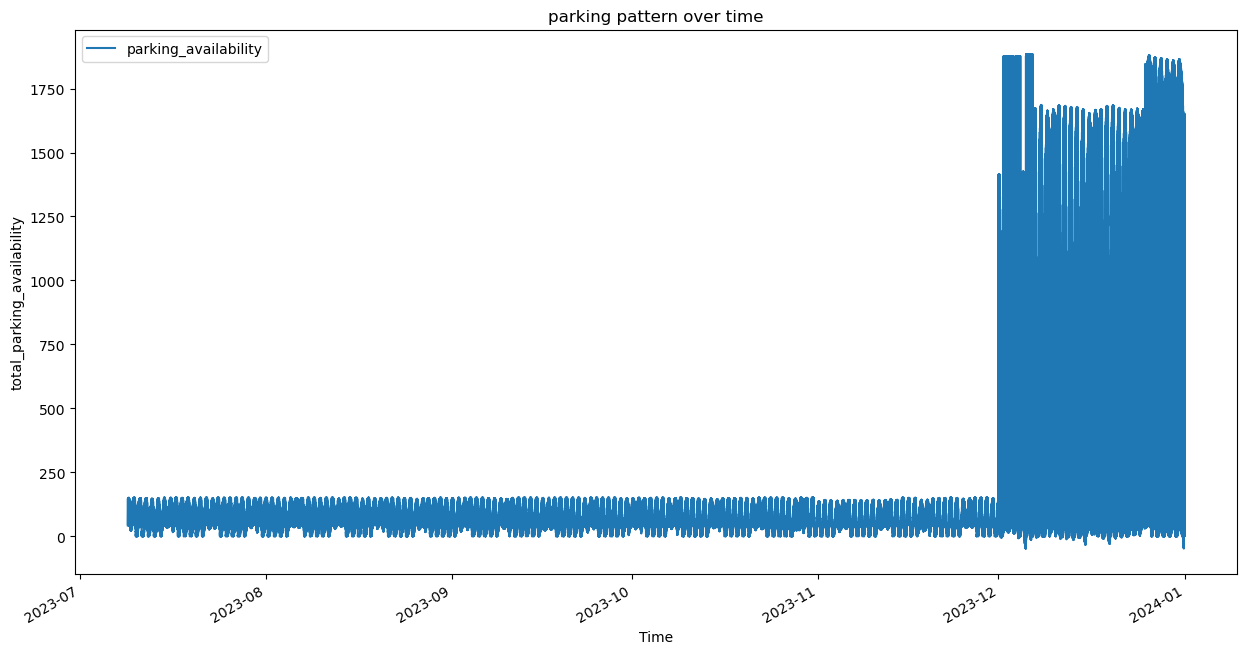

In [11]:
#plotting the parking availability trend
plotting_data.plot(figsize = (15, 8))
plt.title("parking pattern over time")
plt.xlabel('Time')
plt.ylabel("total_parking_availability")
plt.show()

Our time series data has high frequency or irregular time intervals, we considered resampling to a lower frequency to obtain a more meaningful plot. Resampling allows you to aggregate data over specified time intervals, in our case we shall resample the data down to day, week and month
#
We wrote a function to help us plot the patterns

In [12]:
#helper function for plotting patterns
def parking_pattern(data, size):
    data.plot(figsize = (15, 8))
    plt.title(f"parking pattern on a {size} basis")
    plt.xlabel('Time')
    plt.ylabel("total_parking_availability")
    plt.show()

1. Daily pattern of parking availability

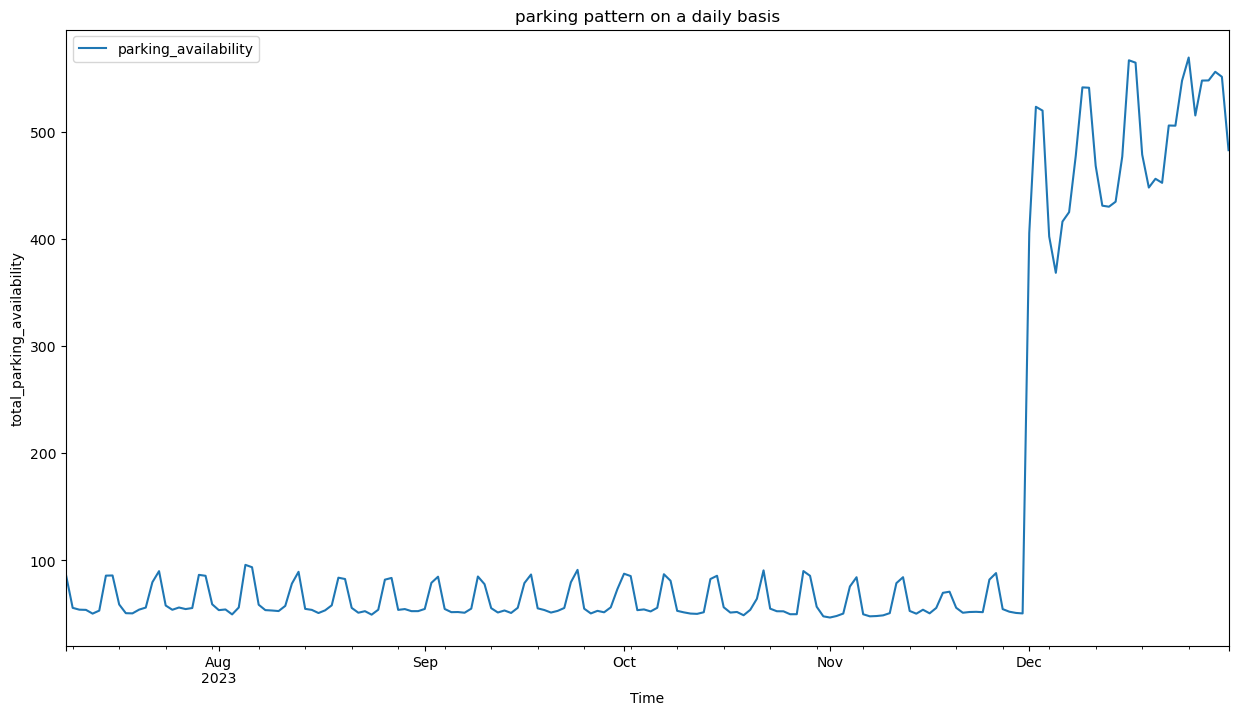

In [13]:
daily_pattern = plotting_data.resample("D").mean()
parking_pattern(daily_pattern, "daily")

2. Weekly pattern

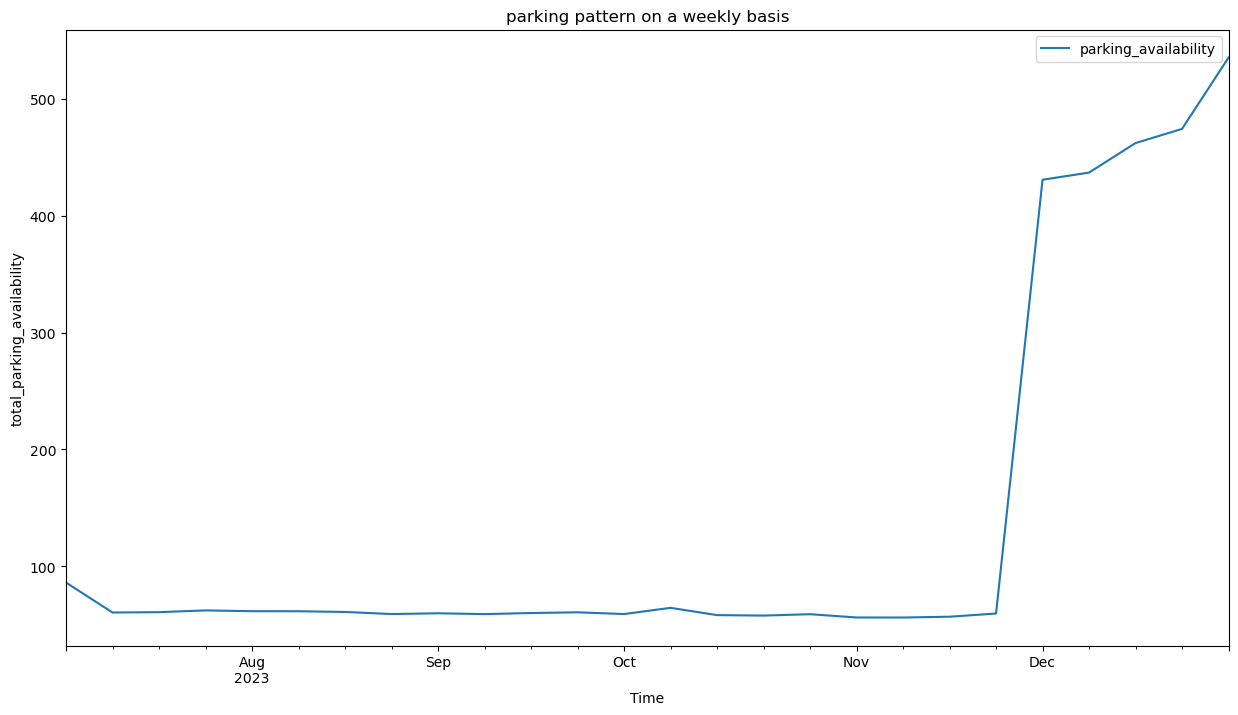

In [14]:
weekly_pattern = plotting_data.resample("W").mean()
parking_pattern(weekly_pattern, "weekly")

Monthly parking pattern

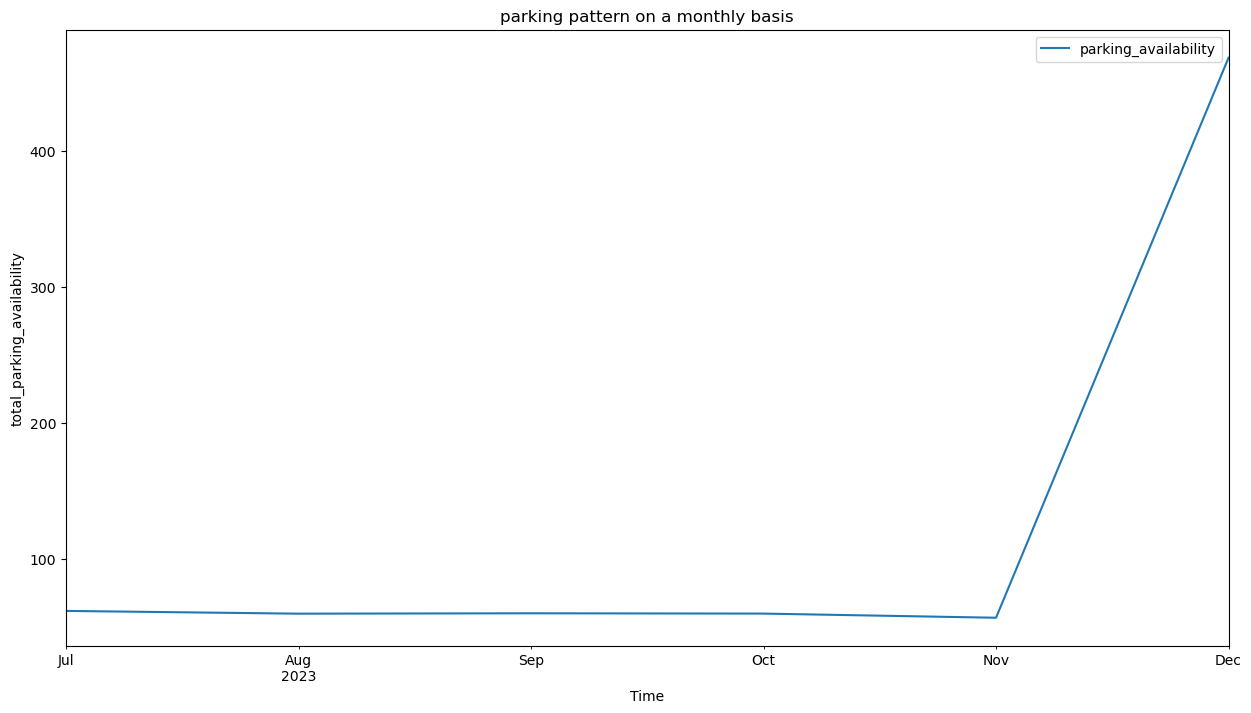

In [15]:
monthly_pattern = plotting_data.resample("M").mean()
parking_pattern(monthly_pattern, "monthly")

Checking for stationarity. A time series is considered stationary if its statistical properties, such as mean, variance, and autocorrelation, do not change over time. In simple words, the time series data shows consistent behavior and does not exhibit trends or seasonality.

In [16]:
#importing adfuller test from statsmodels
from statsmodels.tsa.stattools import adfuller
def stationarity_test(dataset):
    ad_test = adfuller(dataset, autolag = "AIC")
    print("1. ADF: ",ad_test[0])
    print("2. p-value: ",ad_test[1])
    print("3. Number of lags: ", ad_test[2])
    print("4. Number of obeservations used for ADF regression and critical values calculation: ", ad_test[3])
    print("5. Critical values: ")
    

In [17]:
# stationarity_test(plotting_data["total_parking_spots"])

instantiating the `autoarima model` for our time series problem

In [18]:
# from pmdarima import auto_arima
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# #fitting the model
# auto_arima_model = auto_arima(plotting_data["parking_availability"], trace= True, suppress_warnings= True)

In [19]:
daily_pattern

parking_availability
timestamp                       
2023-07-09             86.091106
2023-07-10             55.566964
2023-07-11             53.878049
2023-07-12             53.682893
2023-07-13             50.186798
...                          ...
2023-12-27            547.711993
2023-12-28            547.839515
2023-12-29            555.895052
2023-12-30            551.223979
2023-12-31            482.752599

[176 rows x 1 columns]

Now that we already know the behavior of our data, the model to use and and the order to specify we will go ahead and train a model and make some few predictions. We are also going to split our data into train, test and validation

In [20]:
#importing arima model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
#splitting data
train_data, test_data = train_test_split(daily_pattern, test_size= 0.3, random_state= 42)

In [21]:
#instantiating ARIMA model
arima_model = ARIMA(train_data, order = (2, 1, 2))
arima_model = arima_model.fit()
arima_model.summary()

e:\anaconda3\envs\mwiti-clone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\anaconda3\envs\mwiti-clone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\anaconda3\envs\mwiti-clone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\anaconda3\envs\mwiti-clone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\anaconda3\e

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     parking_availability   No. Observations:                  123
Model:                   ARIMA(2, 1, 2)   Log Likelihood                -799.475
Date:                  Wed, 14 Feb 2024   AIC                           1608.950
Time:                          09:19:25   BIC                           1622.970
Sample:                               0   HQIC                          1614.644
                                  - 123                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5834      0.808     -0.722      0.470      -2.167       1.001
ar.L2         -0.1243      0.109     -1.145      0.252      -0.337       0.089
ma.L1         -0.4754      2.494     -0.191      0.849      -5.364       4.413
ma.L2         -0.5243      1.734     -0.302      0.762      -3.922       2.874
sigma2      2.769e+04   6.96e+04      0.398      0.691   -1.09e+05    1.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                56.43
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                             1.59
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We will also do a prediction to see how well our model has learnt. For the predict method, you need to pass in the start and end parameters for the period you want to predict

In [22]:
#specifying start and end
start = len(train_data)
end = len(train_data) + len(test_data)-1
predictions = arima_model.predict(start = start, end= end, type = "level")
predictions.index = plotting_data.index[start:end+1]
print(round(predictions, 2))


timestamp
2023-12-01 06:20:02    154.40
2023-12-01 06:21:02    143.76
2023-12-01 06:21:42    136.82
2023-12-01 06:24:01    142.19
2023-12-01 06:24:06    139.92
2023-12-01 06:24:13    140.58
2023-12-01 06:24:19    140.48
2023-12-01 06:25:38    140.45
2023-12-01 06:25:43    140.48
2023-12-01 06:28:24    140.47
2023-12-01 06:28:30    140.47
2023-12-01 06:29:01    140.47
2023-12-01 06:29:20    140.47
2023-12-01 06:31:51    140.47
2023-12-01 06:33:01    140.47
2023-12-01 06:33:46    140.47
2023-12-01 06:33:55    140.47
2023-12-01 06:34:03    140.47
2023-12-01 06:34:27    140.47
2023-12-01 06:34:55    140.47
2023-12-01 06:35:13    140.47
2023-12-01 06:35:56    140.47
2023-12-01 06:36:12    140.47
2023-12-01 06:37:26    140.47
2023-12-01 06:37:47    140.47
2023-12-01 06:38:00    140.47
2023-12-01 06:38:06    140.47
2023-12-01 06:38:12    140.47
2023-12-01 06:38:56    140.47
2023-12-01 06:39:04    140.47
2023-12-01 06:39:21    140.47
2023-12-01 06:39:27    140.47
2023-12-01 06:39:59    140.47


e:\anaconda3\envs\mwiti-clone\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Plotting prediction against  actual for a given time series to see how the model behaves visually

<Axes: xlabel='timestamp'>

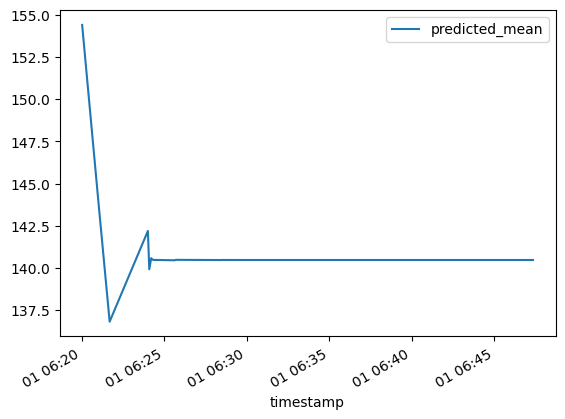

In [23]:
predictions.plot(legend =True)
# daily_pattern["parking_availability"].plot(legend= True)


If you want to see exactly how good or bad it is we can check the `mae` and the `rmse` of our train and test data then compare it to the mean of our dataset

In [24]:
print(daily_pattern.mean())

parking_availability    136.861683
dtype: float64


In [25]:
#getting the mse and rmse
pred_rmse = sqrt(mean_squared_error(predictions, test_data))
print(pred_rmse)

160.1989244609256


The rmse range is greater than the mean of the data, meaning that for every prediction we make we are  getting a value 160.2 further away from the actual result. This means that our model is not performing well and needs improvement

In [26]:
# arima_model2 = ARIMA(plotting_data, order= (2,1,2))
# arima_model2 = arima_model2.fit()

In [27]:
# #setting up future dates 
# future_dates = pd.date_range(start= "2024-01-01", end = "2024-01-31")
# #making prediction
# future_preds = arima_model2.predict(start = len(plotting_data), end = len(plotting_data)+ 30, type = "levels")
# future_preds.index = future_dates
# print(future_preds)

Viewing the predictions from the `ARIMA` model, we can see there is similarity in the values except for the decimal values. This indicates our model  has not captured most of the seasonality and trend component.Our model maybe also overfitting  to the training data or it may be that the series does not have a strong enough seasonal component.

Having also many facilities makes it hard to interpret the prediction for each facility. To overcome this problem, we are going to group our data using facility name and then model time series for each facility in our dataset. This will ease prediction of a parking availability for a given facility, date and time

In [28]:
grouped_data = dddata.copy()
grouped_data.drop(columns=["ParkID", "zone_id"], axis= 1,inplace= True)

In [29]:
grouped_data

facility_name  total_parking_spots  \
0                   Edmondson Park South Car Park                 1429   
1                   Edmondson Park South Car Park                 1429   
2                   Edmondson Park South Car Park                 1429   
3                   Edmondson Park South Car Park                 1429   
4                   Edmondson Park South Car Park                 1429   
...                                           ...                  ...   
599280  Campbelltown Hurley Street South Car Park                  118   
599281  Campbelltown Hurley Street South Car Park                  118   
599282  Campbelltown Hurley Street South Car Park                  118   
599283  Campbelltown Hurley Street South Car Park                  118   
599284  Campbelltown Hurley Street South Car Park                  118   

        occupancy_total day_of_week        date      time  \
0                    28      Friday  2023-12-01  00:09:20   
1                    27      Friday  2023-12-01  00:12:57   
2                    26      Friday  2023-12-01  00:13:45   
3                    25      Friday  2023-12-01  00:17:43   
4                    25      Friday  2023-12-01  00:27:43   
...                 ...         ...         ...       ...   
599280               62      Sunday  2023-12-31  23:21:38   
599281               62      Sunday  2023-12-31  23:31:38   
599282               61      Sunday  2023-12-31  23:39:15   
599283               61      Sunday  2023-12-31  23:49:15   
599284               61      Sunday  2023-12-31  23:59:17   

        parking_availability time_category   z_score  
0                       1401         Night  2.535373  
1                       1402         Night  2.537913  
2                       1403         Night  2.540453  
3                       1404         Night  2.542992  
4                       1404         Night  2.542992  
...                      ...           ...       ...  
599280                    56         Night -0.880331  
599281                    56         Night -0.880331  
599282                    57         Night -0.877792  
599283                    57         Night -0.877792  
599284                    57         Night -0.877792  

[599285 rows x 9 columns]

In [30]:
# import prophet
# # Create the ColumnTransformer
# ohe_pipeline = Pipeline(steps=[('enc', OneHotEncoder(drop="first", sparse=False))])
# transformer = ColumnTransformer(transformers=[("ohe", ohe_pipeline, categorical_columns)], remainder="passthrough")

# # Group data by facility_name
# grouped_data = modelling_data.groupby("facility_name")

# # Loop through each facility until the last one
# for facility, facility_data in grouped_data:
#     # Apply OHE within this facility's data
#     transformed_data = transformer.fit_transform(facility_data)

#     # Reconstruct DataFrame with encoded columns
#     transformed_df = pd.DataFrame(transformed_data, columns=transformer.get_feature_names_out())

#     # Select columns for Prophet (assuming 'ds' for datetime, 'occupancy_total' for target)
#     model_data = transformed_df[['ohe__day_of_week_Monday', 'ohe__day_of_week_Saturday',
#     'ohe__day_of_week_Sunday', 'ohe__day_of_week_Thursday',
#     'ohe__day_of_week_Tuesday', 'ohe__day_of_week_Wednesday',
#     'ohe__time_category_Early Morning', 'ohe__time_category_Evening',
#     'ohe__time_category_Late Afternoon', 'ohe__time_category_Morning',
#     'ohe__time_category_Night', 'remainder__total_parking_spots',
#     'remainder__occupancy_total', 'remainder__parking_availability',
#     'remainder__z_score', 'date', 'time']] 

#     # Create and fit Prophet model
#     model = prophet.Prophet()
#     model.fit(model_data)

#     # Make predictions for a specified future period (e.g., next week)
#     future = model.make_future_dataframe(periods=prediction_period)
#     forecast = model.predict(future)

#     # Analyze and store results for this facility (optional)
#     # ...

#     # Check if this is the last facility
#     if next(iter(grouped_data), None) is None:  # Check if there are no more facilities
#         print("Processed predictions for all facilities")
#         break

# # Further analysis or visualization using predictions/models for each facility (optional)
# # ...



We will create a class for the `Prophet` that iterates over grouped data does time series using given columns and allows us to make predictions  on future data. 

First lets preprocess our categorical/string dtype columns

In [31]:
from datetime import datetime
#function to conver to datetime
def to_datetime(x):
    return datetime.strptime(x,  "%Y-%m-%d %H:%M:%S")

pprophet_data = pd.read_csv("modelling_data.csv", parse_dates= [["date", "time"]], date_parser= to_datetime)

In [32]:
#setting datetime as index
prophet_data = pprophet_data.drop(["day_of_week", "time_category", "ParkID", "zone_id", "z_score"], axis= 1)
prophet_data = prophet_data.set_index("date_time").groupby("facility_name").resample("D").mean()
#inspecting our data
prophet_data.head()

total_parking_spots  occupancy_total  \
facility_name        date_time                                          
Bella Vista Car Park 2023-12-01                777.0       332.854559   
                     2023-12-02                777.0       197.873521   
                     2023-12-03                777.0       137.133550   
                     2023-12-04                777.0       346.532401   
                     2023-12-05                777.0       409.501304   

                                 parking_availability  
facility_name        date_time                         
Bella Vista Car Park 2023-12-01            444.145441  
                     2023-12-02            579.126479  
                     2023-12-03            639.866450  
                     2023-12-04            430.467599  
                     2023-12-05            367.498696

We have two index columns in our grouped dataframe, we will reset the index, return `date_time` as the index and plot  and do some visualizations on our facilities

In [33]:
#resetting index
prophet_data = prophet_data.reset_index()


Plotting all trends in one plot

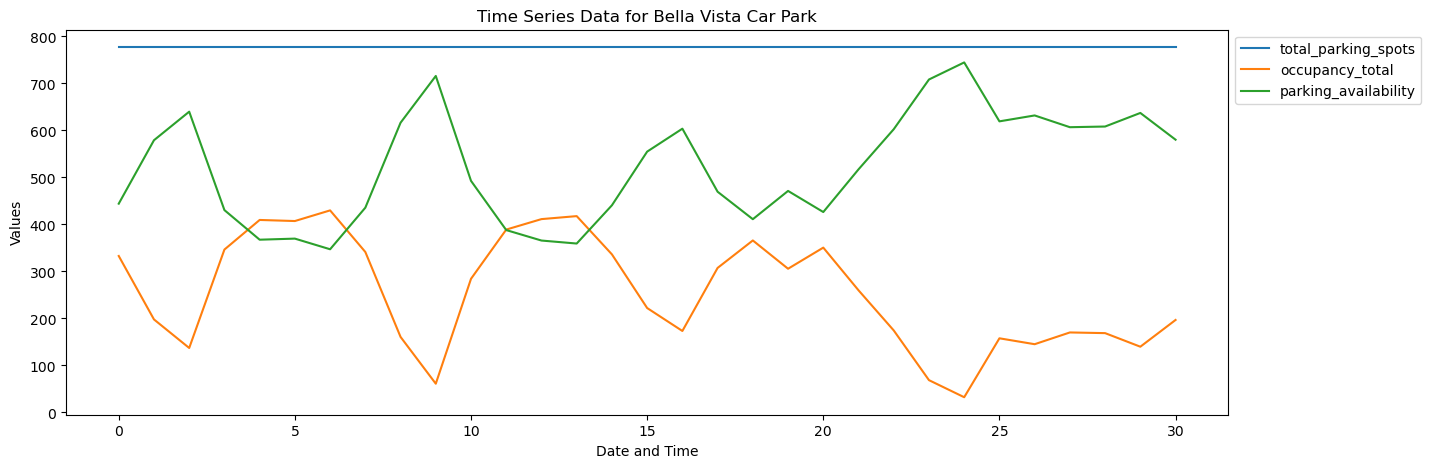

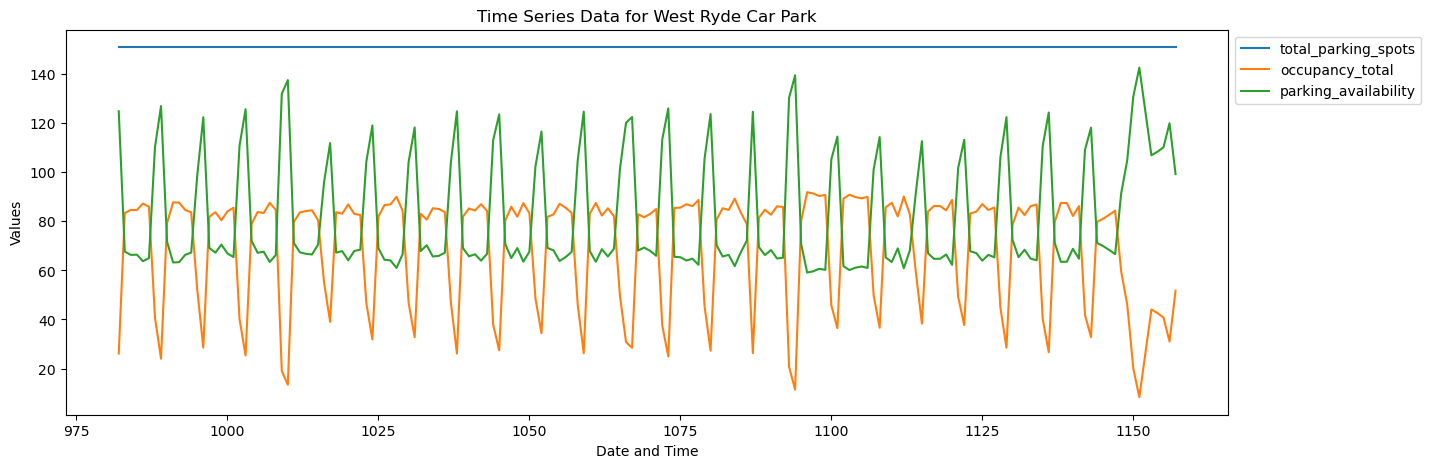

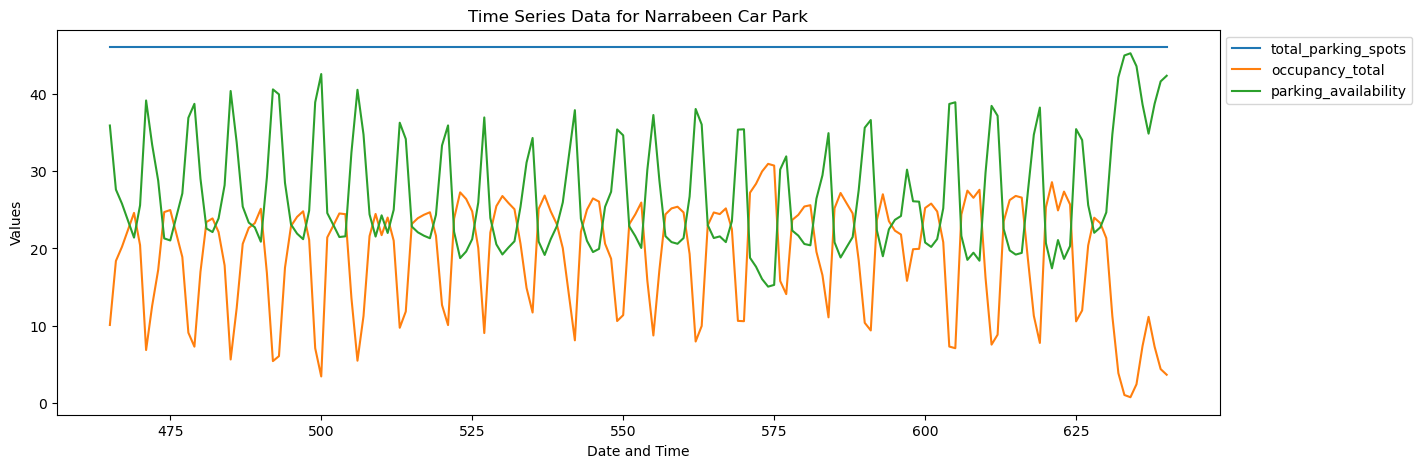

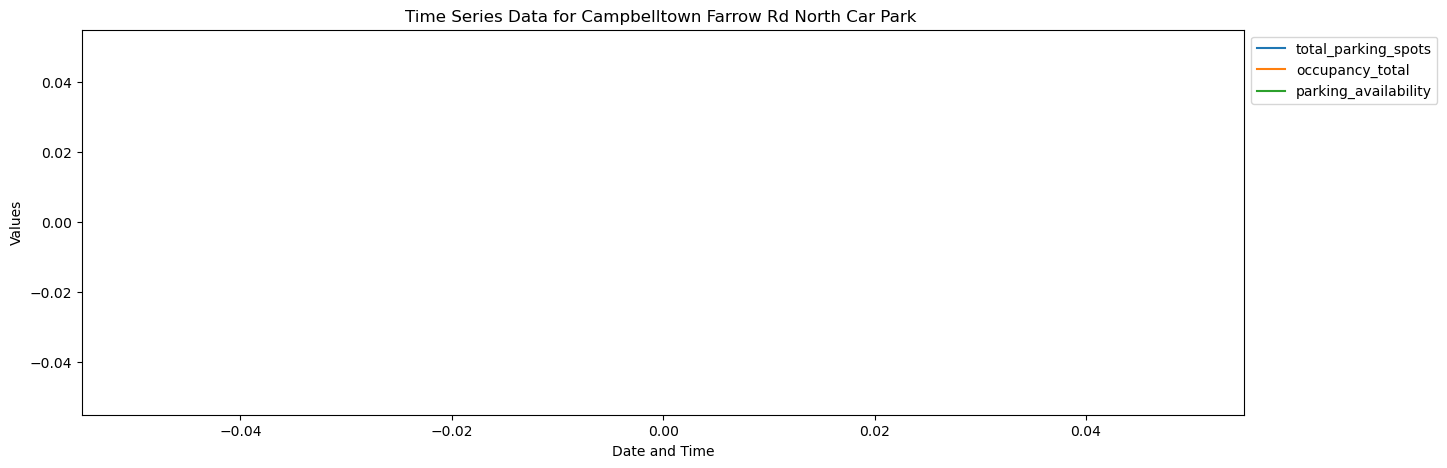

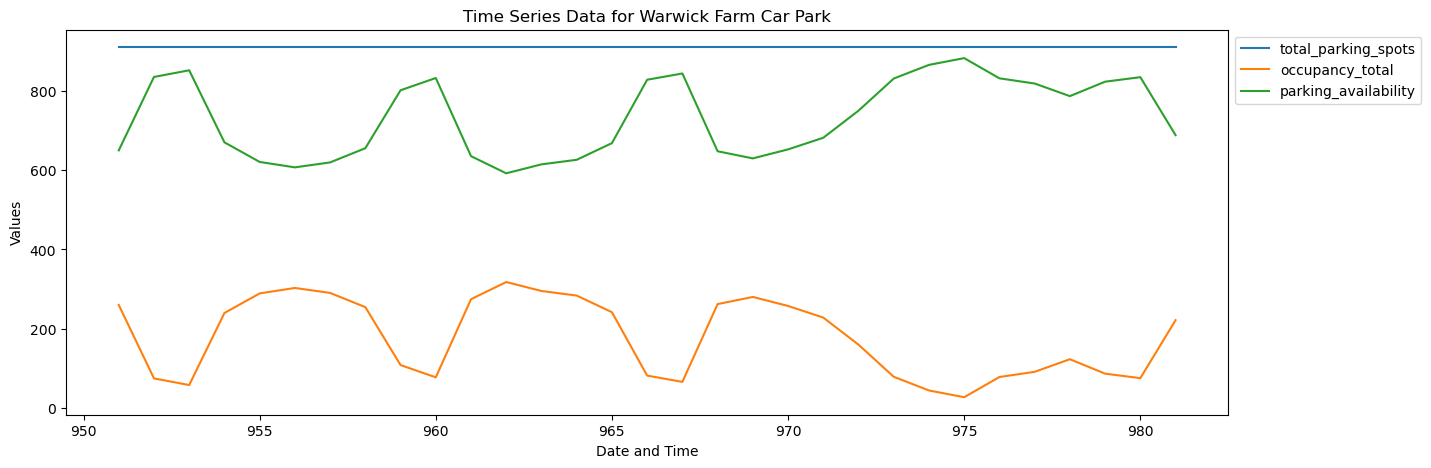

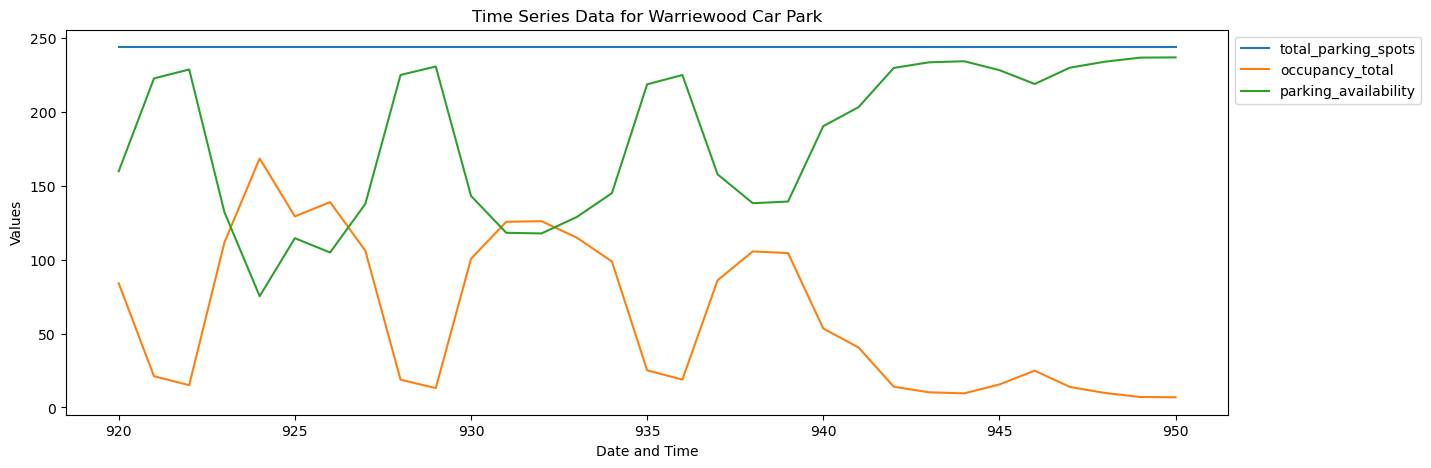

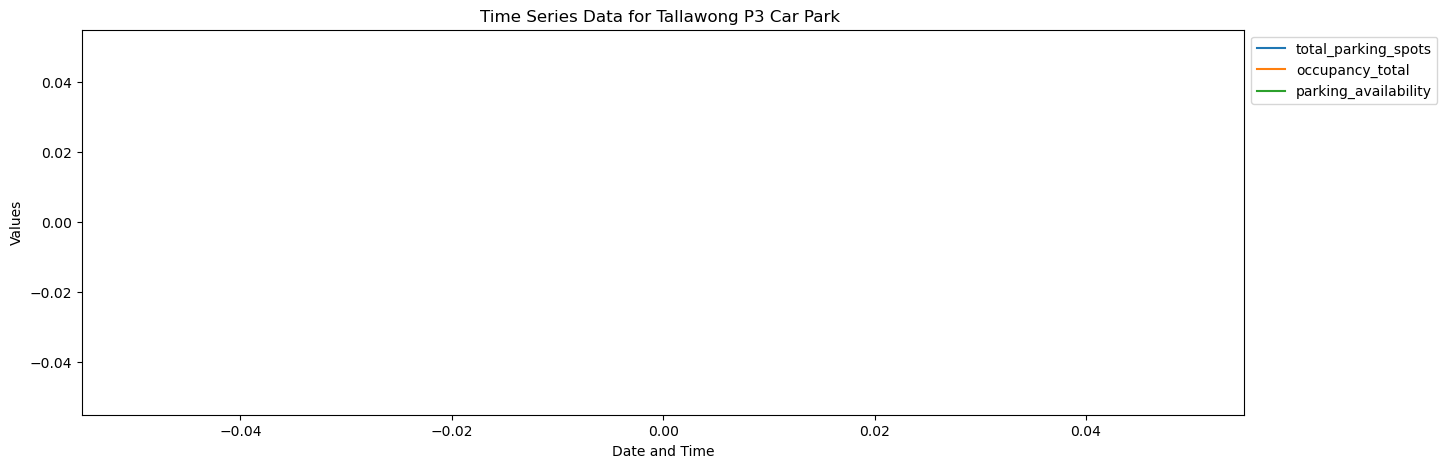

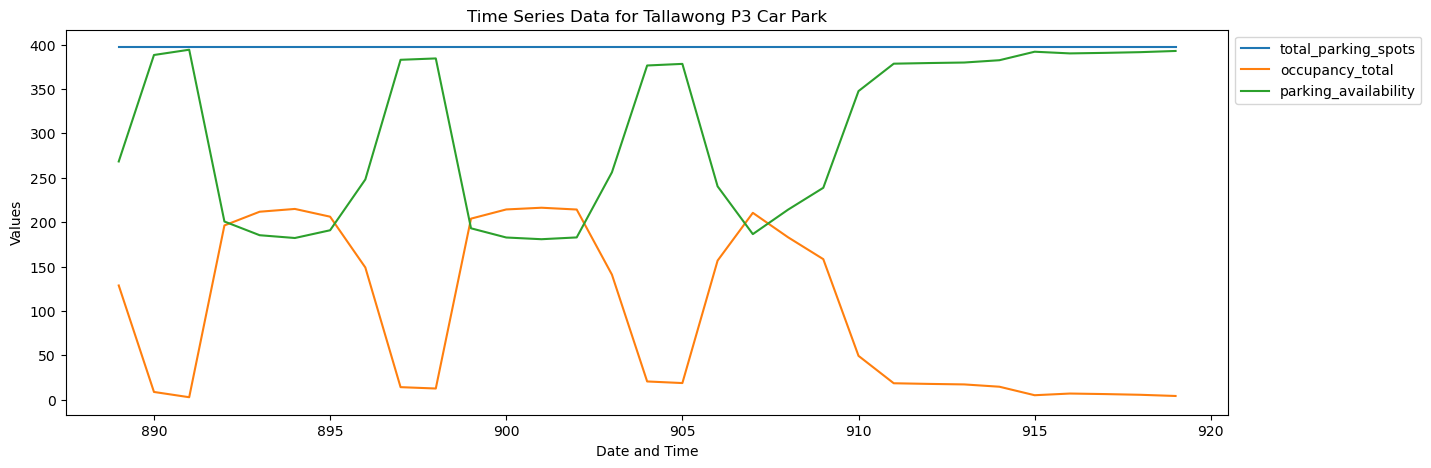

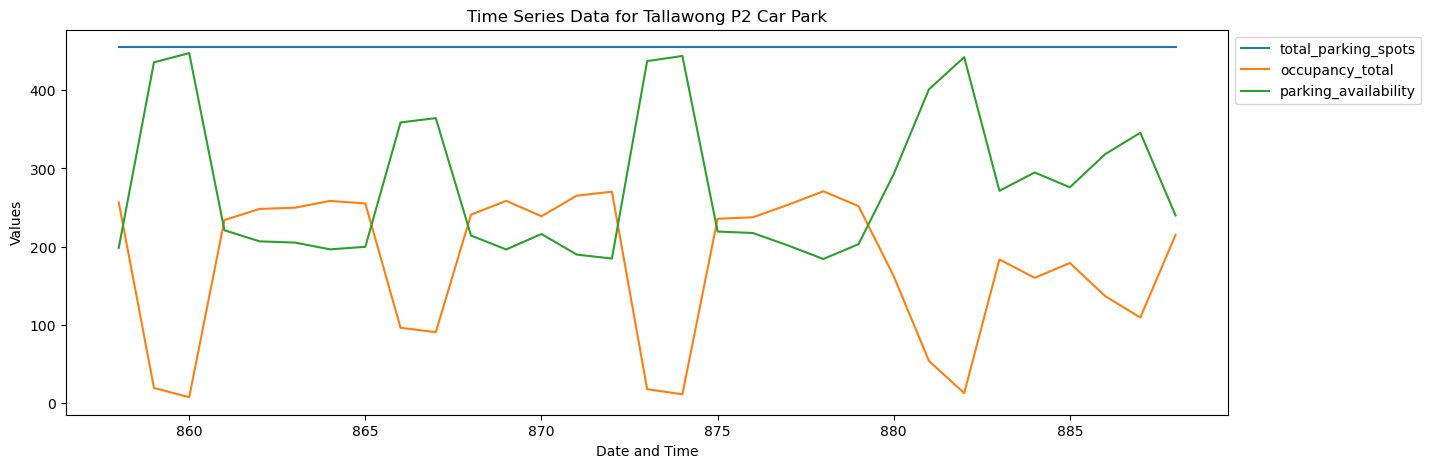

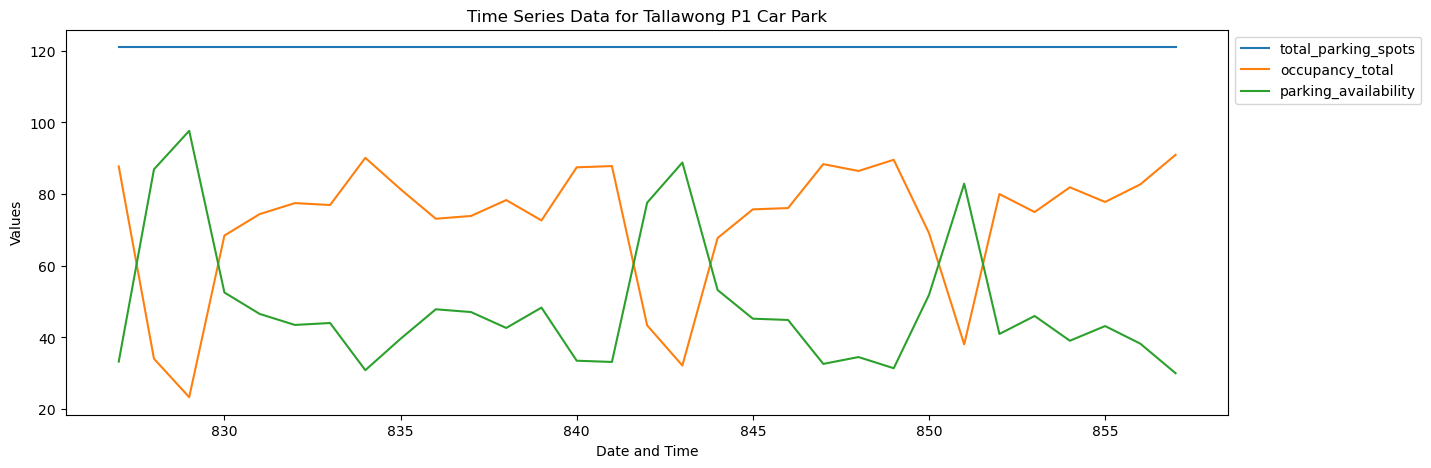

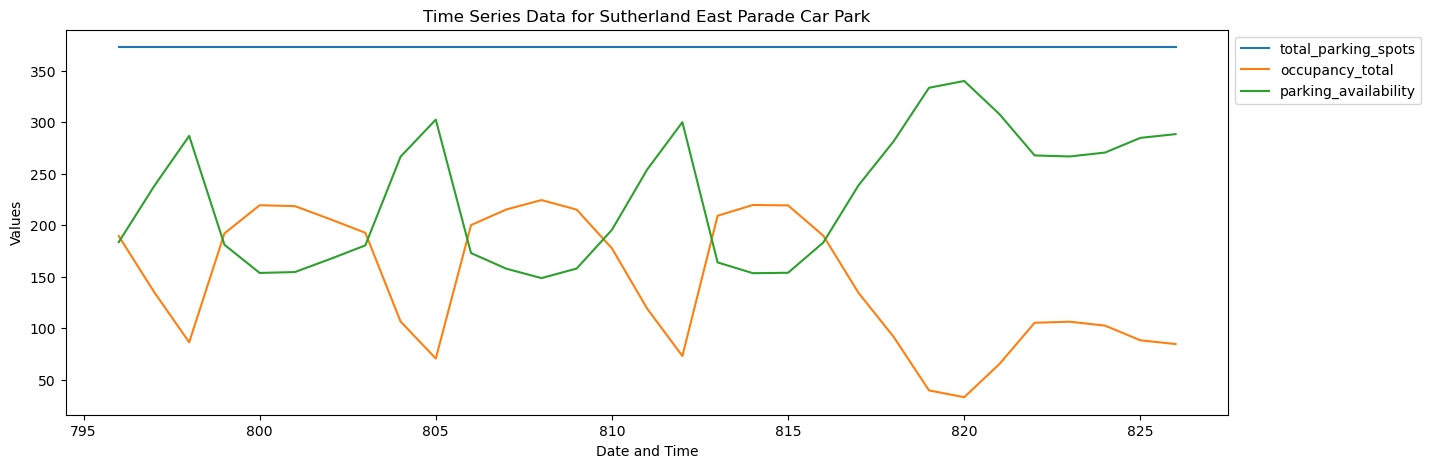

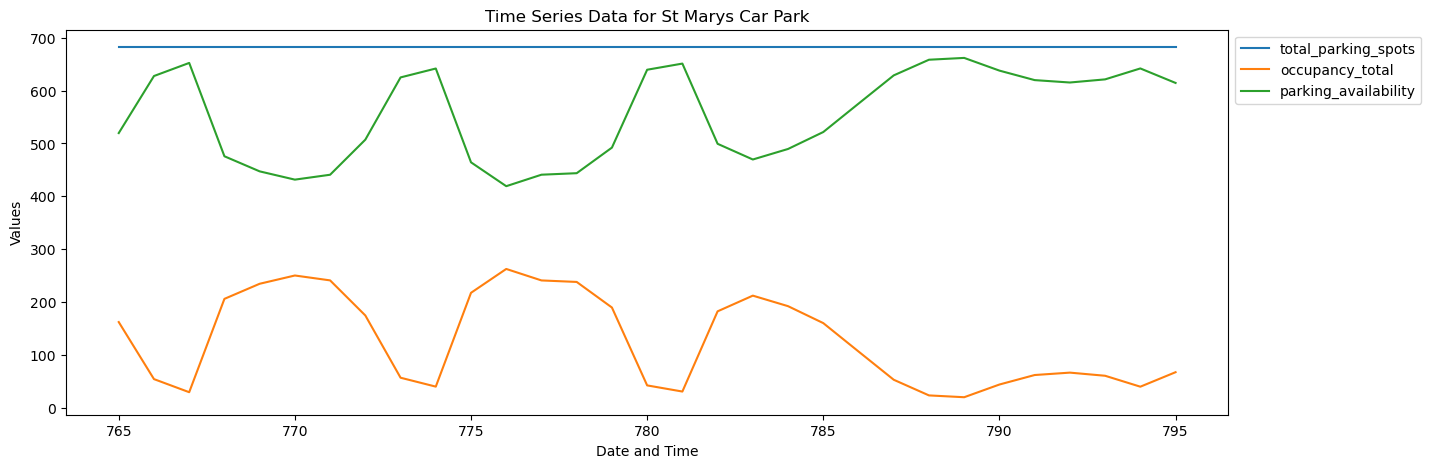

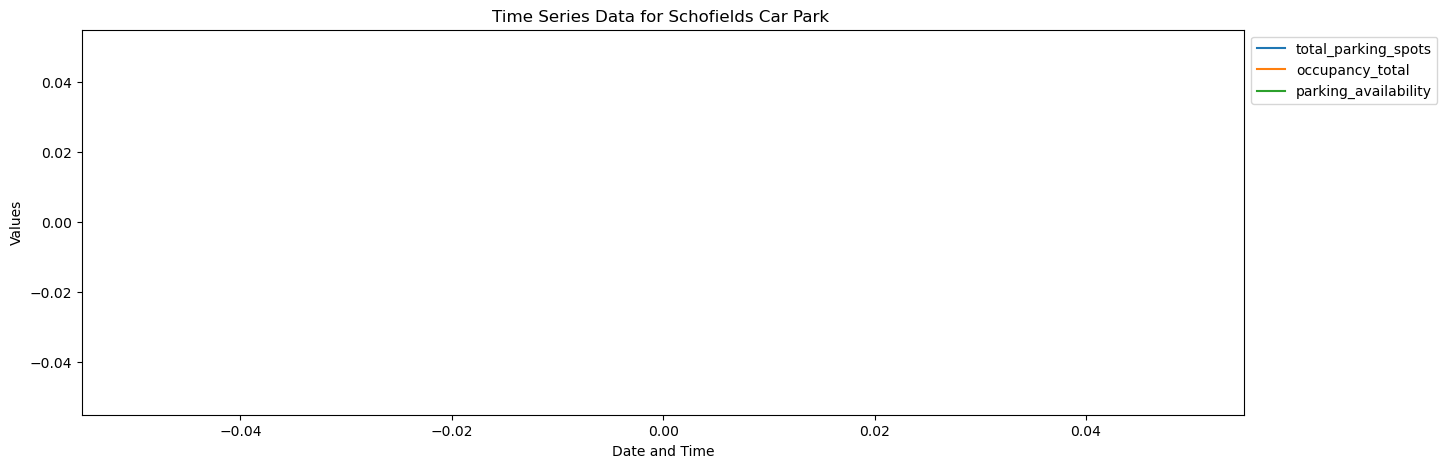

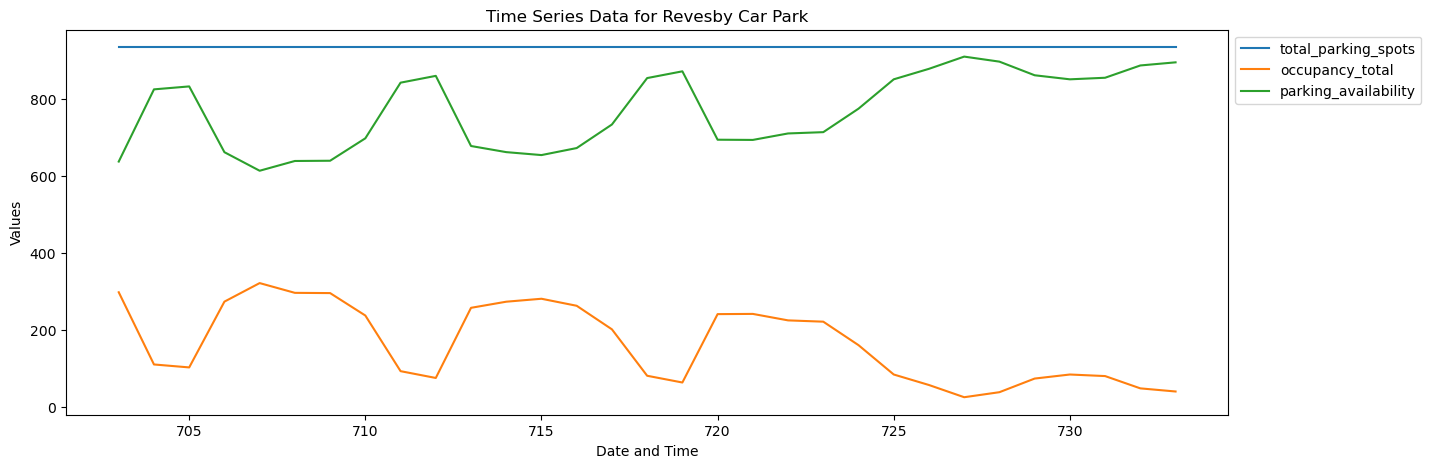

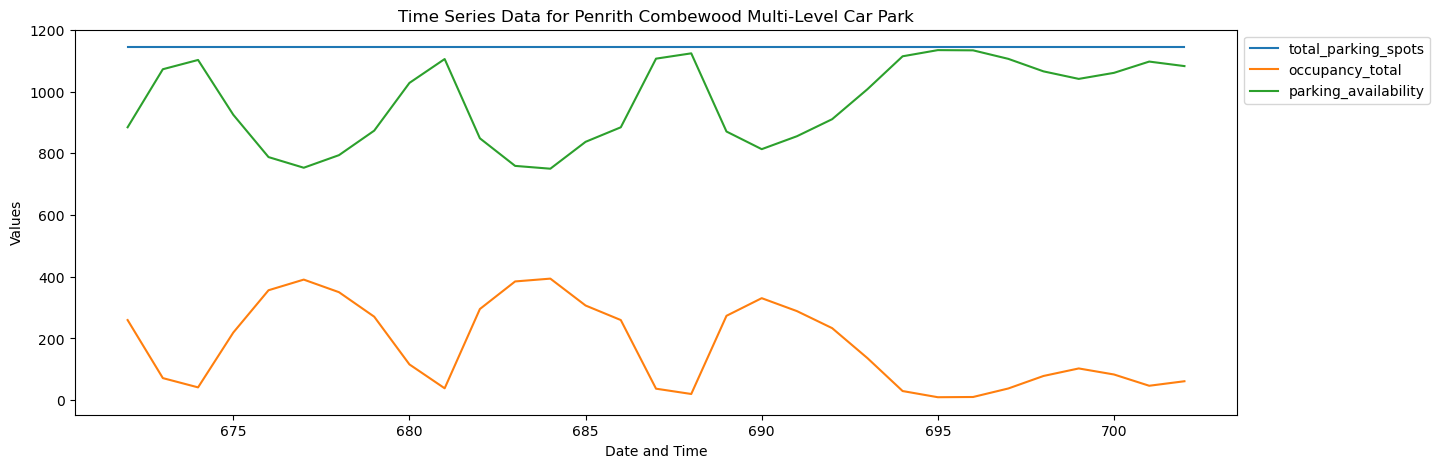

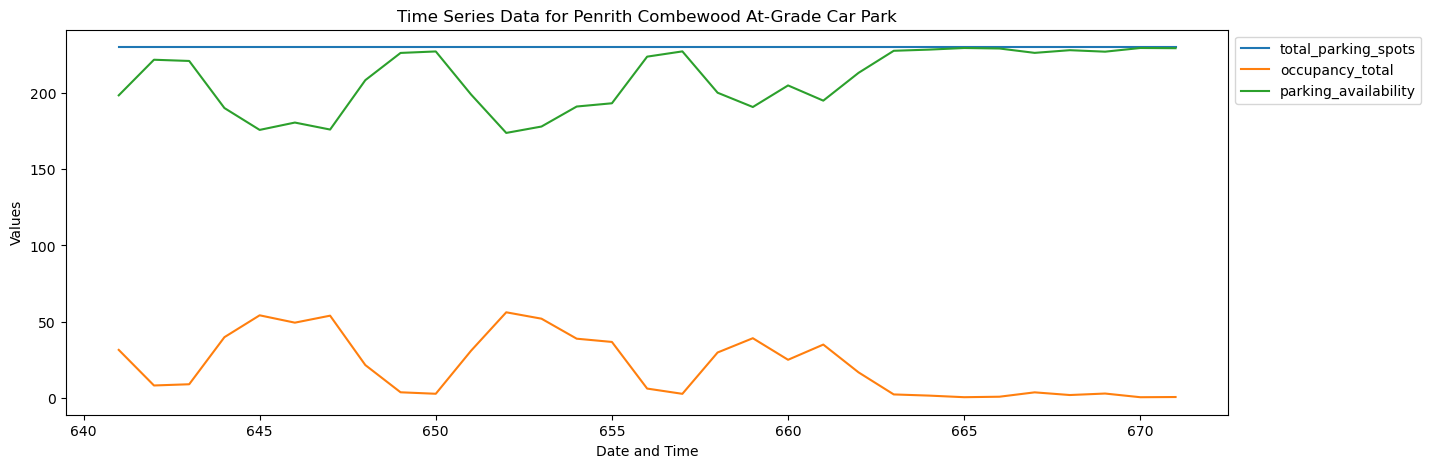

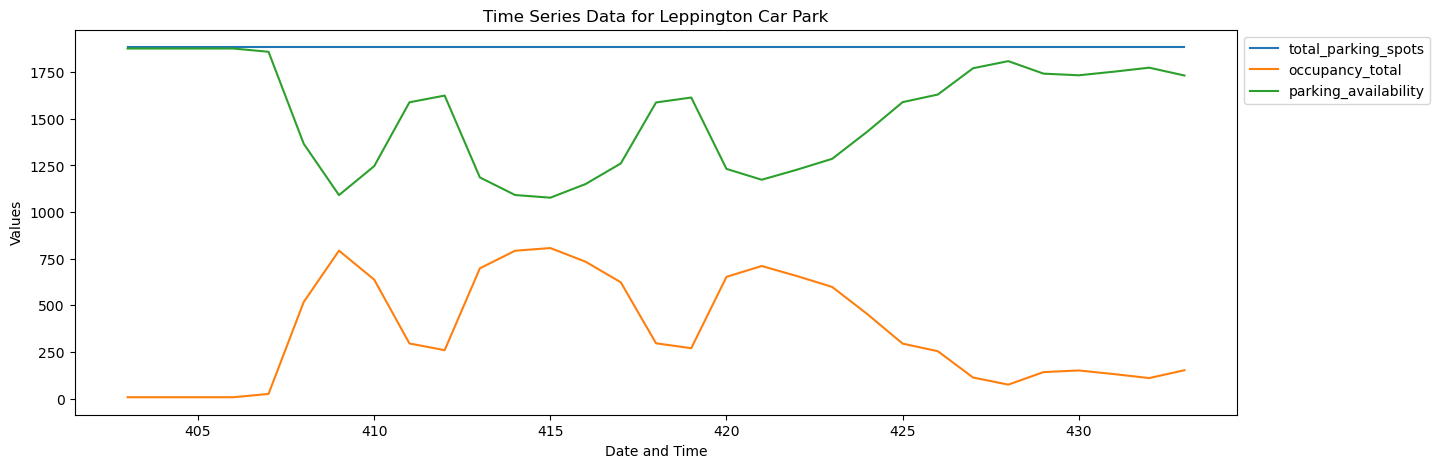

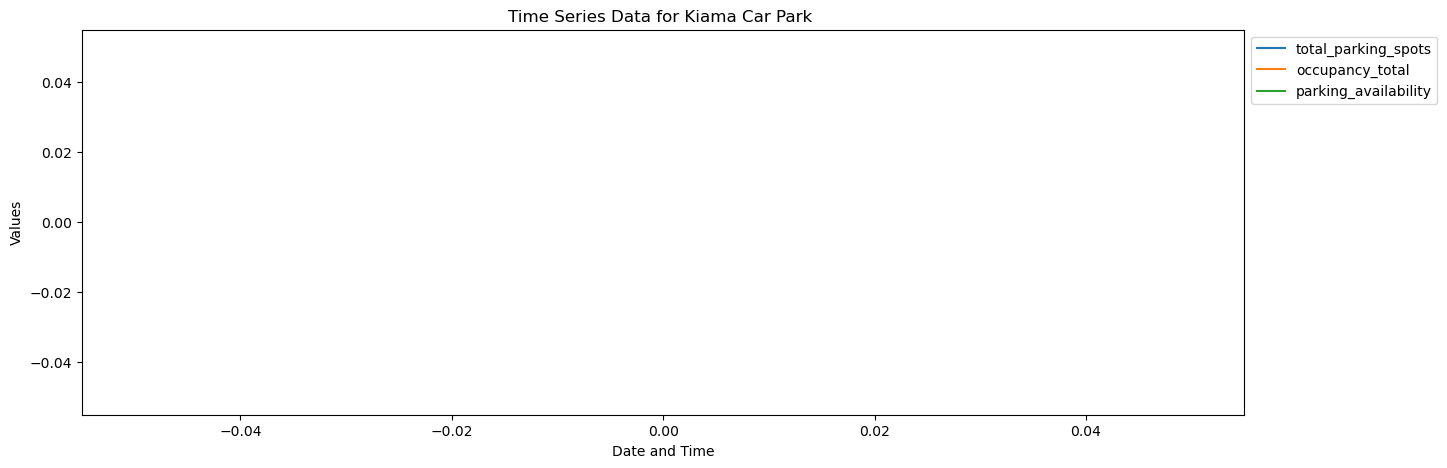

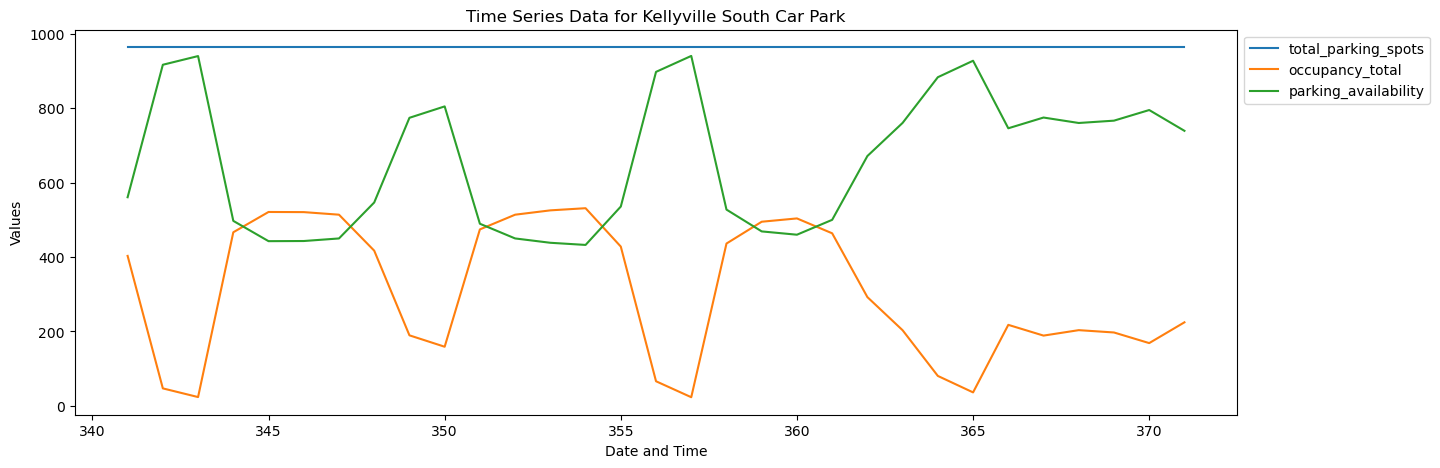

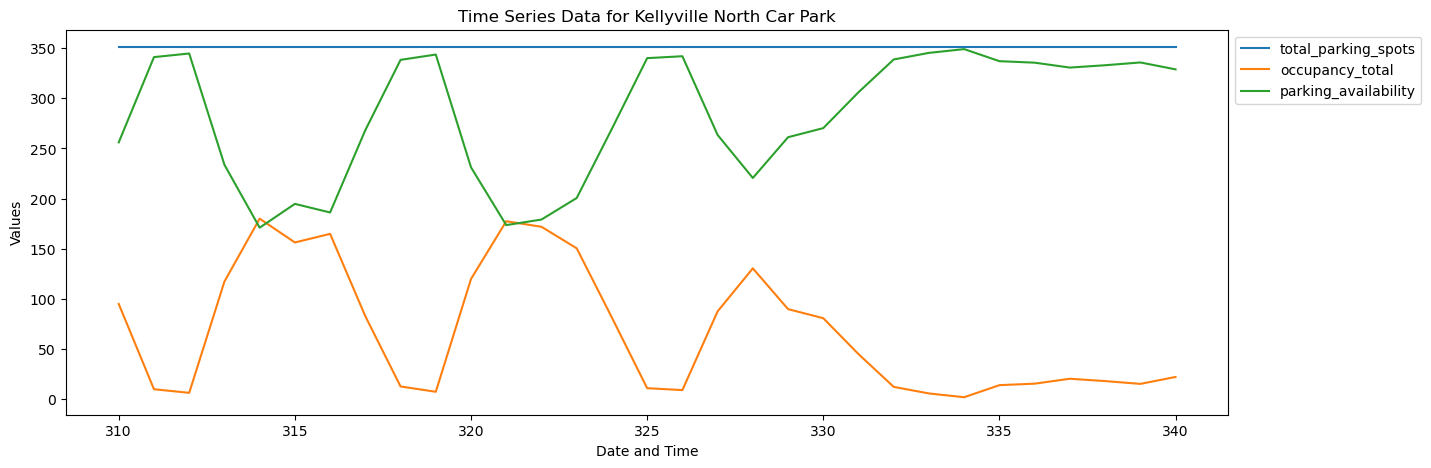

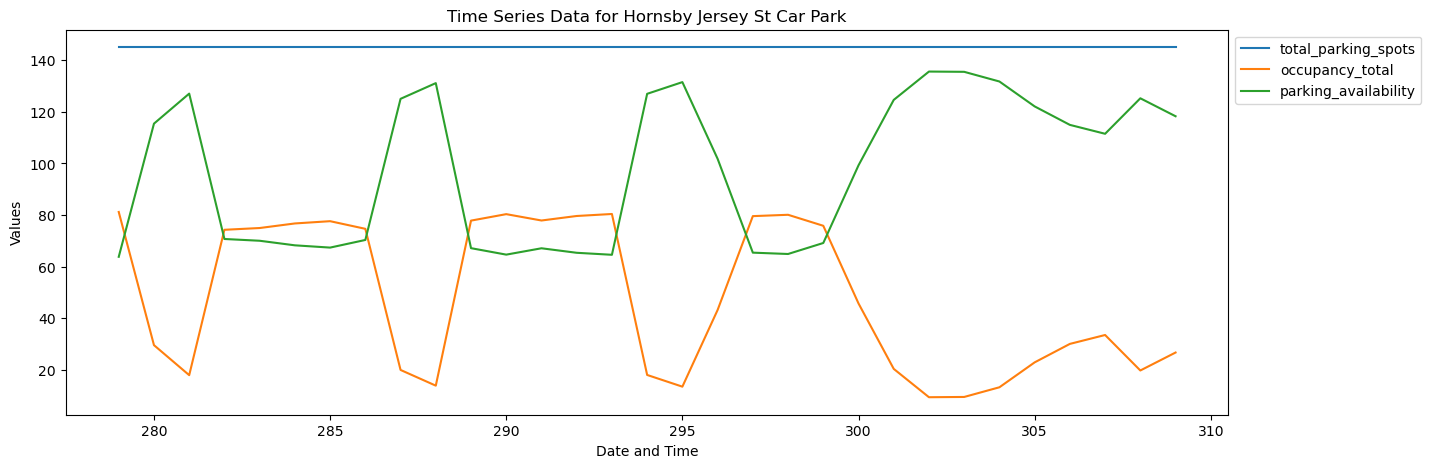

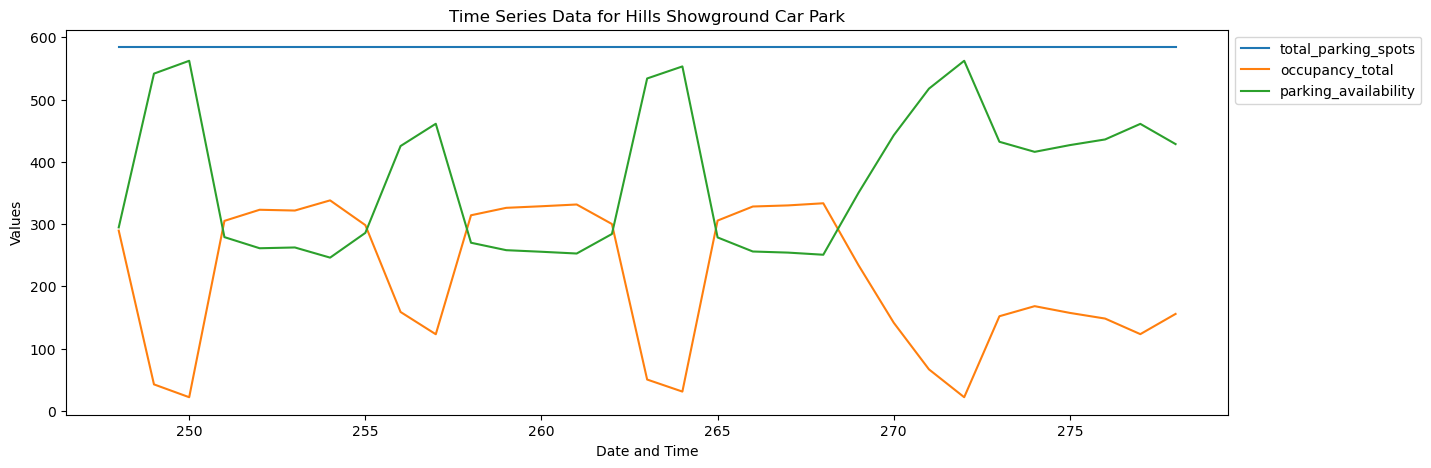

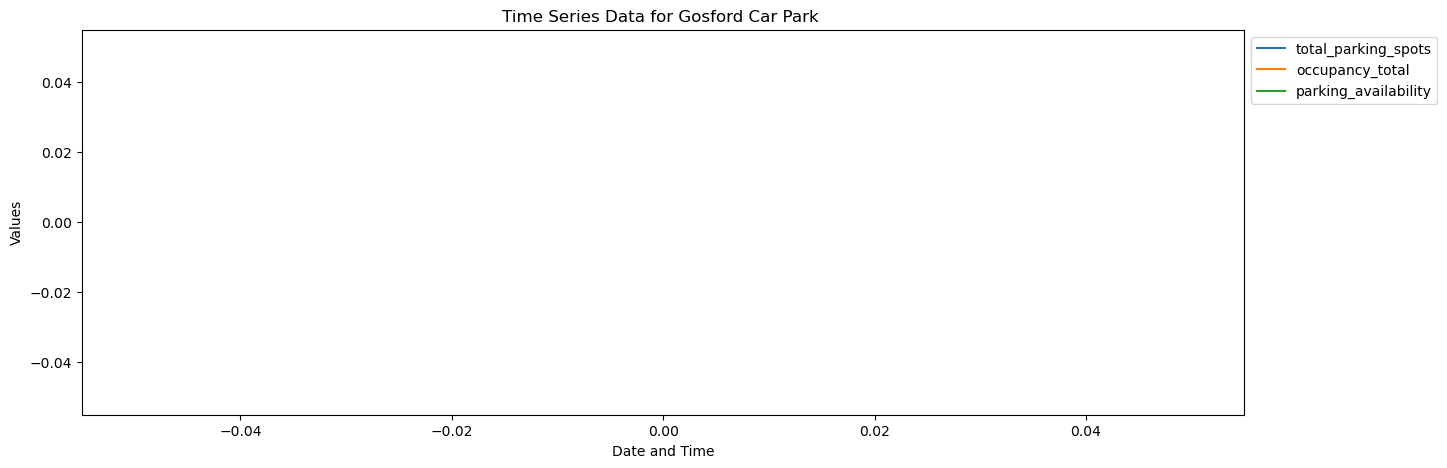

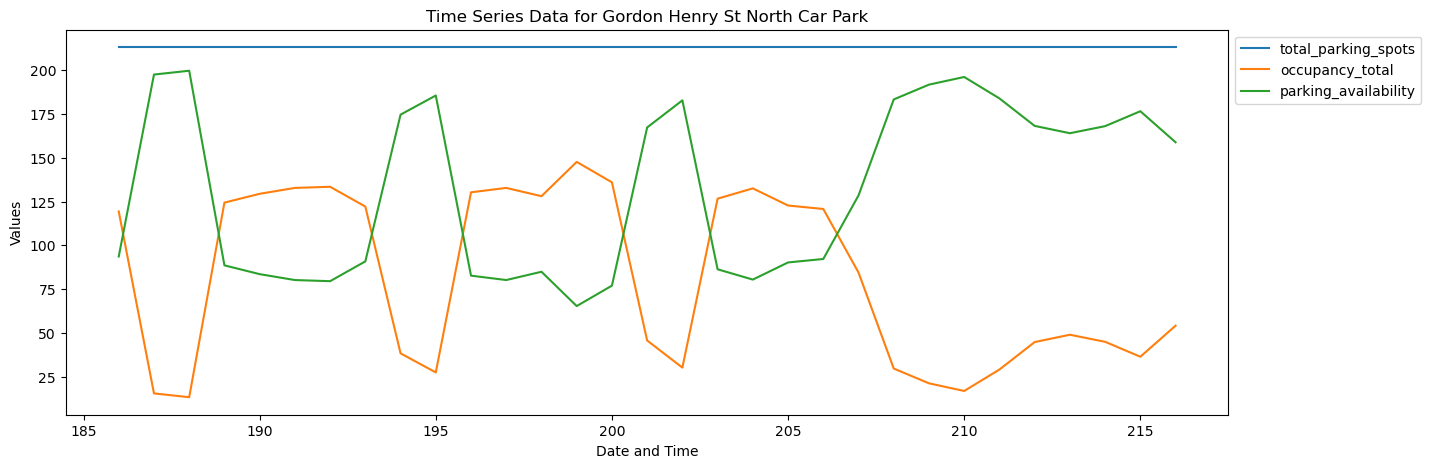

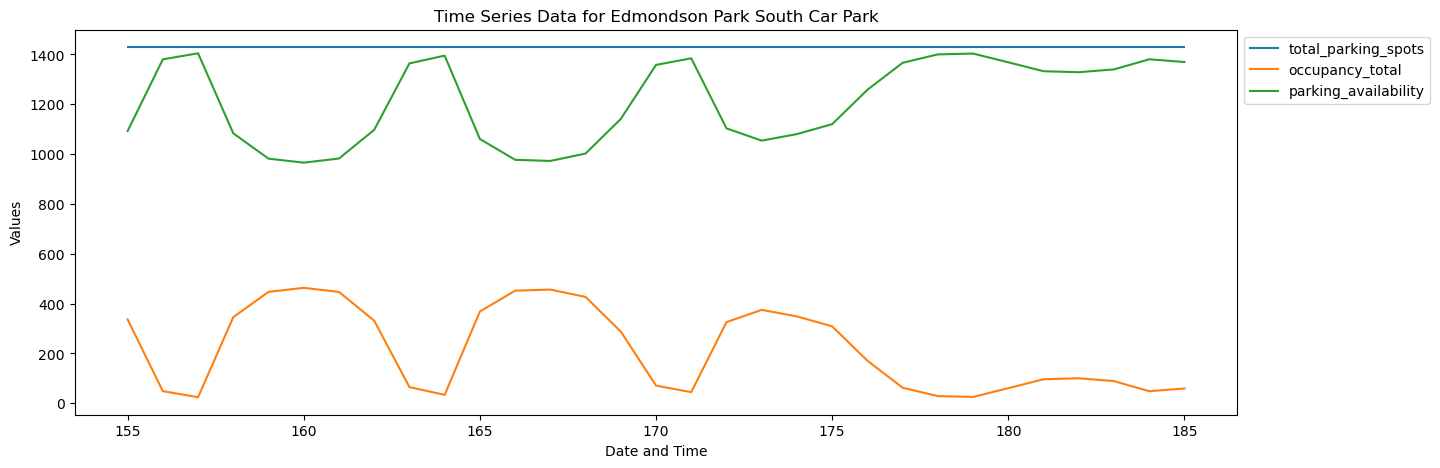

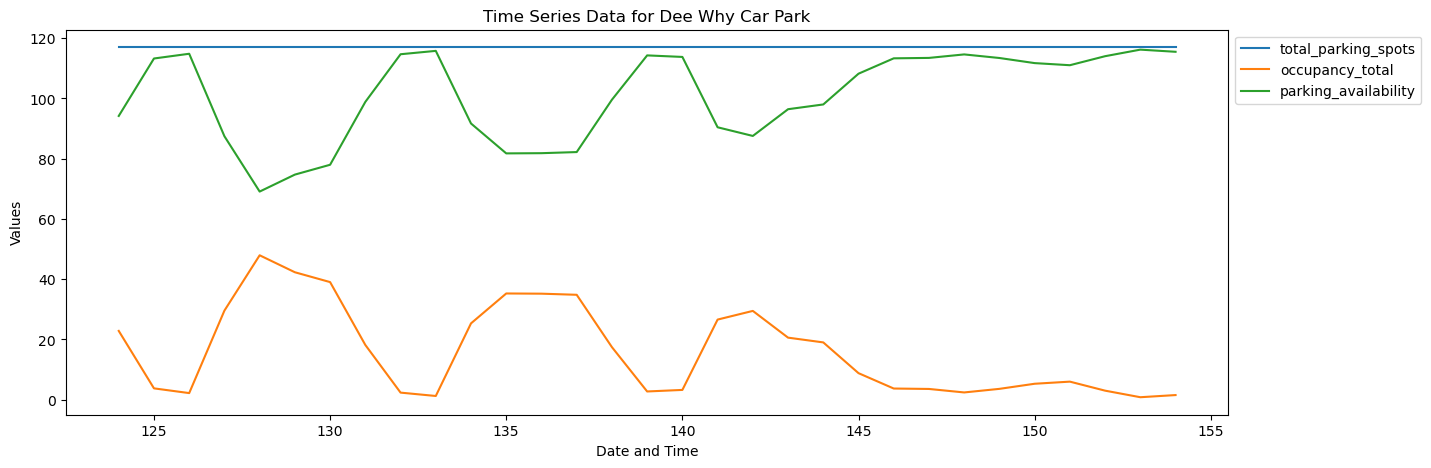

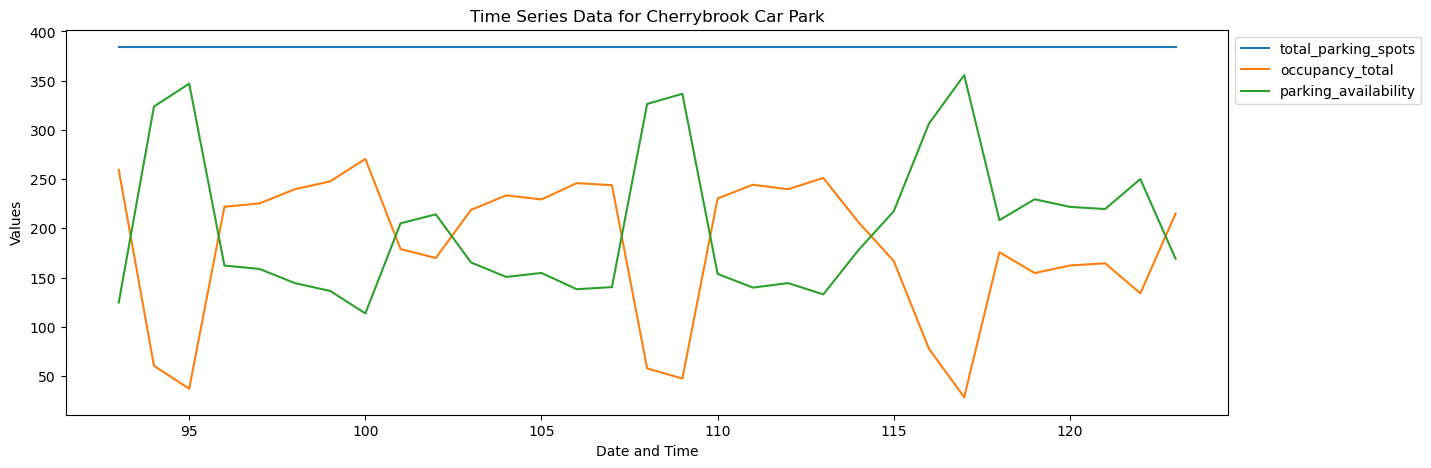

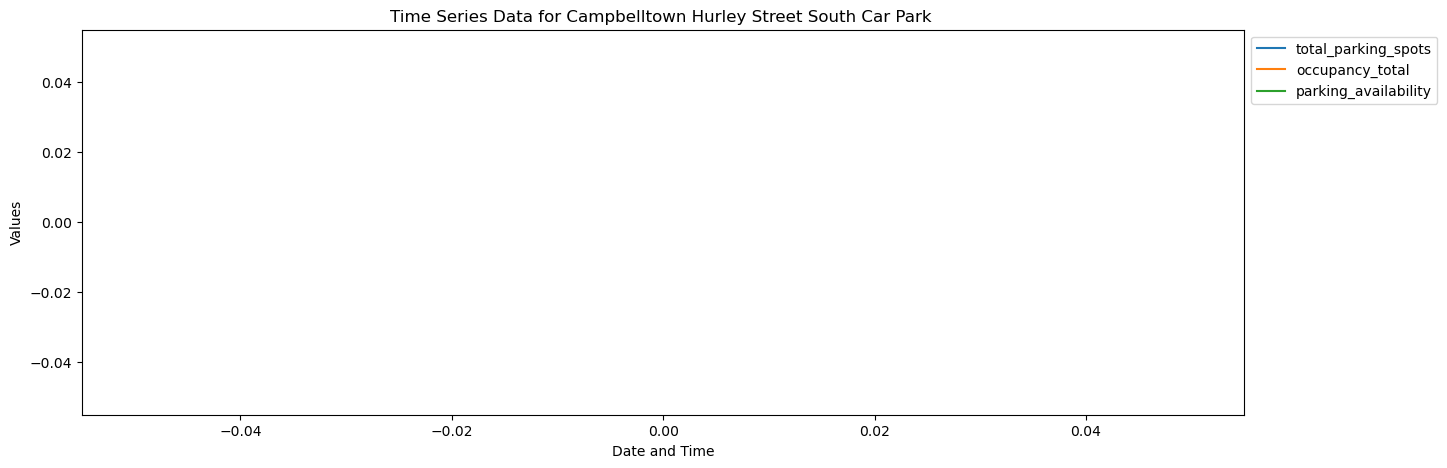

In [34]:
import matplotlib.pyplot as plt

def plot_facilities(data, facilities, columns=["total_parking_spots", "occupancy_total", "parking_availability"], figsize=(15, 5)):
    # Set the 'date_time' column as the index
    data.set_index("date_time")

    # Filter data for the specified facilities
    filtered_data = data[data['facility_name'].isin(facilities)]

    for facility in facilities:
        facility_data = filtered_data.query(f"facility_name == '{facility}'")

        # Create a new figure for each facility
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot the data for the current facility
        facility_data[columns].plot(ax=ax, label=facility)

        # Set title, labels, and legend
        ax.set_title(f"Time Series Data for {facility}")
        ax.set_xlabel("Date and Time")
        ax.set_ylabel("Values")
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

        plt.show()

# Example usage
facilities_to_plot = ["Bella Vista Car Park", "West Ryde Car Park", "Narrabeen Car Park", "Campbelltown Farrow Rd North Car Park " ,
                    "Warwick Farm Car Park", "Warriewood Car Park", "Tallawong P3 Car Park ", "Tallawong P3 Car Park", "Tallawong P2 Car Park",
                    "Tallawong P1 Car Park", "Sutherland East Parade Car Park", "St Marys Car Park", "Schofields Car Park ", "Revesby Car Park",
                    "Penrith Combewood Multi-Level Car Park", "Penrith Combewood At-Grade Car Park", "Leppington Car Park", "Kiama Car Park ",
                    "Kellyville South Car Park", "Kellyville North Car Park", "Hornsby Jersey St Car Park", "Hills Showground Car Park", "Gosford Car Park ",
                    "Gordon Henry St North Car Park", "Edmondson Park South Car Park", "Dee Why Car Park", "Cherrybrook Car Park", "Campbelltown Hurley Street South Car Park "]
plot_facilities(prophet_data, facilities_to_plot, figsize=(15, 5))




Voila! We can see our parking facilities have different seasonalities and trends. We can not generalize this and build one time series model. What we will do is to create separate models for each of the facility, which will allow us to make accurate predictions and forecasting.

In [35]:
prophet_data

facility_name  date_time  total_parking_spots  occupancy_total  \
0     Bella Vista Car Park 2023-12-01                777.0       332.854559   
1     Bella Vista Car Park 2023-12-02                777.0       197.873521   
2     Bella Vista Car Park 2023-12-03                777.0       137.133550   
3     Bella Vista Car Park 2023-12-04                777.0       346.532401   
4     Bella Vista Car Park 2023-12-05                777.0       409.501304   
...                    ...        ...                  ...              ...   
1153    West Ryde Car Park 2023-12-27                151.0        44.062500   
1154    West Ryde Car Park 2023-12-28                151.0        42.627692   
1155    West Ryde Car Park 2023-12-29                151.0        40.794304   
1156    West Ryde Car Park 2023-12-30                151.0        31.003378   
1157    West Ryde Car Park 2023-12-31                151.0        51.720721   

      parking_availability  
0               444.145441  
1               579.126479  
2               639.866450  
3               430.467599  
4               367.498696  
...                    ...  
1153            106.937500  
1154            108.372308  
1155            110.205696  
1156            119.996622  
1157             99.279279  

[1158 rows x 5 columns]

#### 2. Prophet model
Prophet is a time series forecasting tool developed by Facebook that utilizes an additive model to capture seasonality, trends, and holidays, providing a user-friendly approach for accurate and efficient predictions.
#
We will create a final dataframe that has the date_time column and the columns we will need for our analysis. Prophet model expects data in a particular format; it expects the name of date column to be "ds" and the target variable as y
#
Before everything we will create a prophet pipeline

In [36]:

#creating a pipeline
prophet_pipeline = Pipeline(steps=[
    ("prophet", prophet.Prophet(interval_width = 0.95))
])

In [37]:
final_prophet_data = prophet_data[["facility_name", "date_time", "total_parking_spots",
                    "occupancy_total", "parking_availability"]].rename({"date_time": "ds", "parking_availability": "y"}, axis = "columns")
final_prophet_data

facility_name         ds  total_parking_spots  occupancy_total  \
0     Bella Vista Car Park 2023-12-01                777.0       332.854559   
1     Bella Vista Car Park 2023-12-02                777.0       197.873521   
2     Bella Vista Car Park 2023-12-03                777.0       137.133550   
3     Bella Vista Car Park 2023-12-04                777.0       346.532401   
4     Bella Vista Car Park 2023-12-05                777.0       409.501304   
...                    ...        ...                  ...              ...   
1153    West Ryde Car Park 2023-12-27                151.0        44.062500   
1154    West Ryde Car Park 2023-12-28                151.0        42.627692   
1155    West Ryde Car Park 2023-12-29                151.0        40.794304   
1156    West Ryde Car Park 2023-12-30                151.0        31.003378   
1157    West Ryde Car Park 2023-12-31                151.0        51.720721   

               y  
0     444.145441  
1     579.126479  
2     639.866450  
3     430.467599  
4     367.498696  
...          ...  
1153  106.937500  
1154  108.372308  
1155  110.205696  
1156  119.996622  
1157   99.279279  

[1158 rows x 5 columns]

Grouping by facility names to allow us to know all the stations and model different time series

In [38]:
facility_names = final_prophet_data.groupby("facility_name")
facility_names.head()

facility_name         ds  total_parking_spots  occupancy_total  \
0    Bella Vista Car Park 2023-12-01                777.0       332.854559   
1    Bella Vista Car Park 2023-12-02                777.0       197.873521   
2    Bella Vista Car Park 2023-12-03                777.0       137.133550   
3    Bella Vista Car Park 2023-12-04                777.0       346.532401   
4    Bella Vista Car Park 2023-12-05                777.0       409.501304   
..                    ...        ...                  ...              ...   
982    West Ryde Car Park 2023-07-09                151.0        26.096154   
983    West Ryde Car Park 2023-07-10                151.0        83.332623   
984    West Ryde Car Park 2023-07-11                151.0        84.679089   
985    West Ryde Car Park 2023-07-12                151.0        84.564356   
986    West Ryde Car Park 2023-07-13                151.0        87.254132   

              y  
0    444.145441  
1    579.126479  
2    639.866450  
3    430.467599  
4    367.498696  
..          ...  
982  124.903846  
983   67.667377  
984   66.320911  
985   66.435644  
986   63.745868  

[140 rows x 5 columns]

Splitting our data into train, test and  validation sets

In [39]:
# for facility in facility_names.groups:
#     group = facility_names.get_group(facility)
#     #train data
#     train = group[(group["ds"]>= "2023-12-01") & (group["ds"]<= "2023-12-16")]
#     #test_data
#     test = group[(group["ds"]>= "2023-12-17") & (group["ds"]<= "2023-12-31")]
    
# print(train.shape)
# print(test.shape)

Creating an empty dataframe so we can build a forecast for the whole 28 facilities

10:16:28 - cmdstanpy - INFO - Chain [1] start processing


10:16:28 - cmdstanpy - INFO - Chain [1] done processing
10:16:28 - cmdstanpy - INFO - Chain [1] start processing
10:16:28 - cmdstanpy - INFO - Chain [1] done processing
10:16:29 - cmdstanpy - INFO - Chain [1] start processing
10:16:29 - cmdstanpy - INFO - Chain [1] done processing
10:16:29 - cmdstanpy - INFO - Chain [1] start processing
10:16:29 - cmdstanpy - INFO - Chain [1] done processing
10:16:29 - cmdstanpy - INFO - Chain [1] start processing
10:16:29 - cmdstanpy - INFO - Chain [1] done processing
10:16:29 - cmdstanpy - INFO - Chain [1] start processing
10:16:29 - cmdstanpy - INFO - Chain [1] done processing
10:16:30 - cmdstanpy - INFO - Chain [1] start processing
10:16:30 - cmdstanpy - INFO - Chain [1] done processing
10:16:30 - cmdstanpy - INFO - Chain [1] start processing
10:16:30 - cmdstanpy - INFO - Chain [1] done processing
10:16:30 - cmdstanpy - INFO - Chain [1] start processing
10:16:30 - cmdstanpy - INFO - Chain [1] done processing
10:16:30 - cmdstanpy - INFO - Chain [1] 

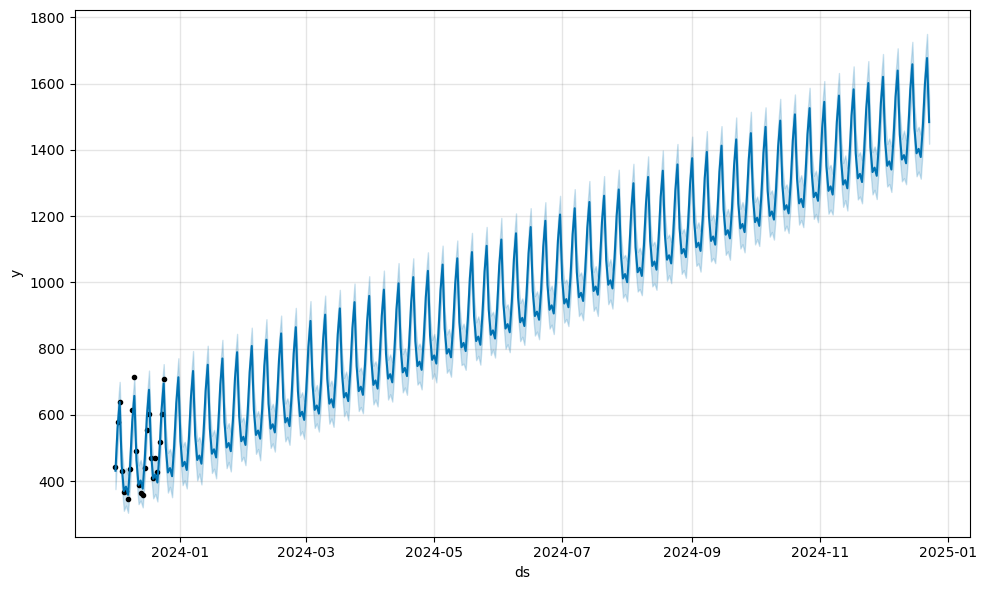

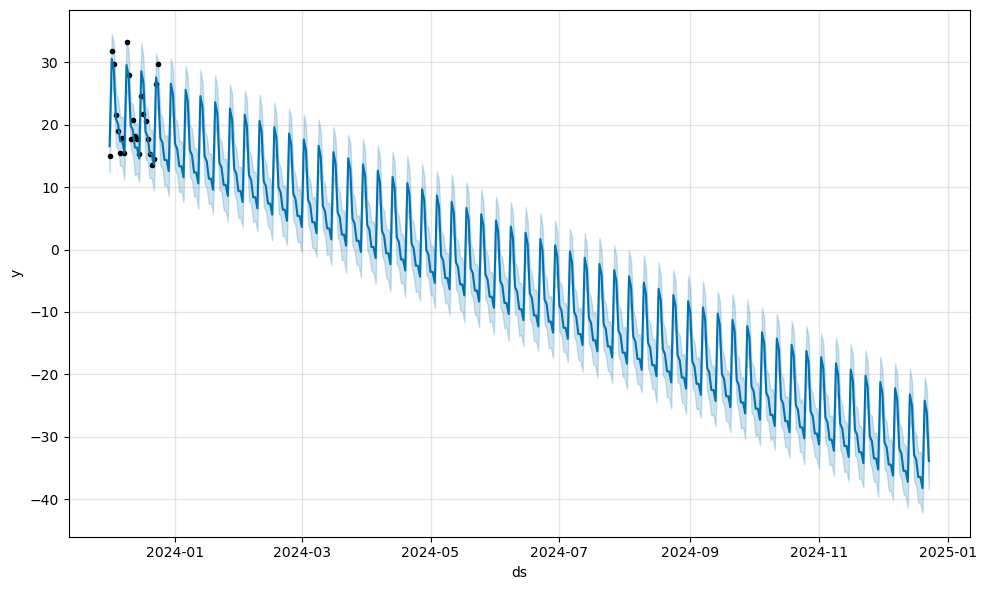

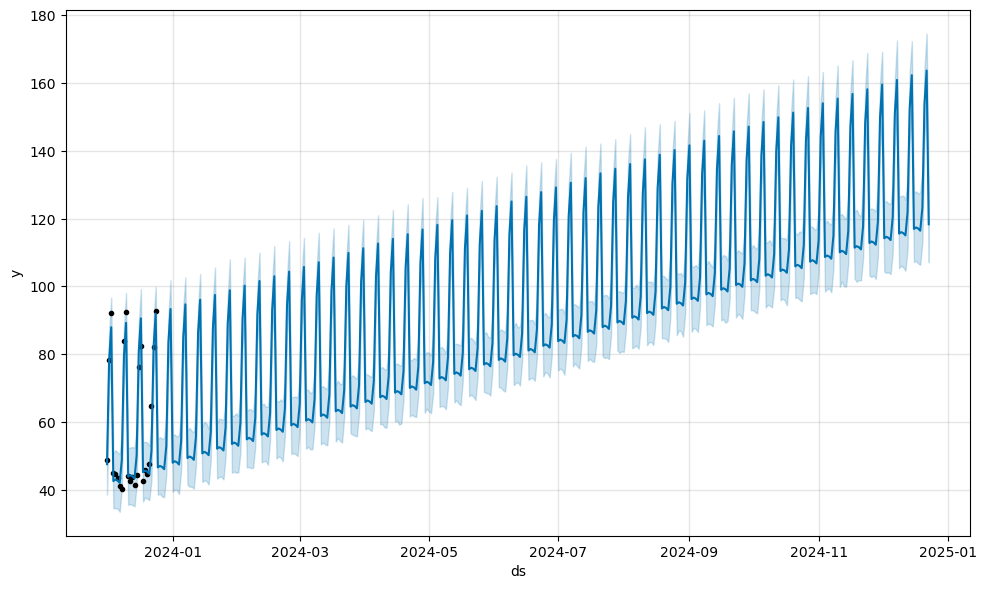

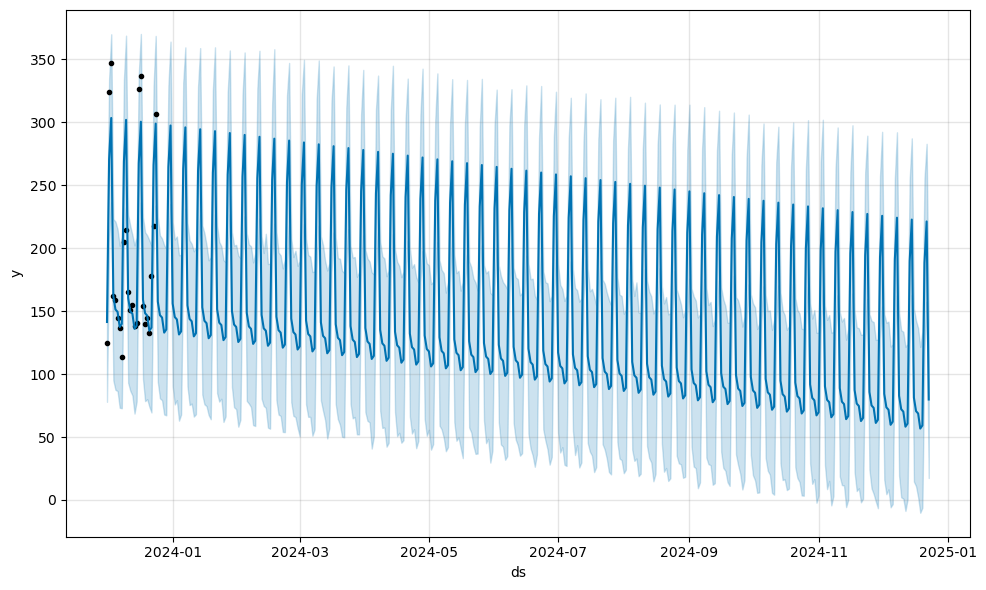

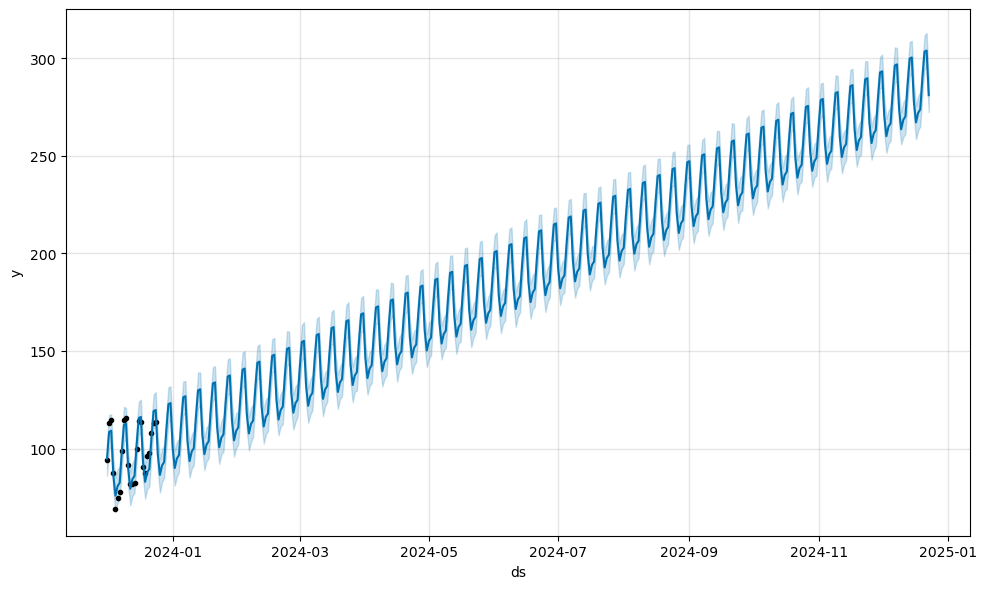

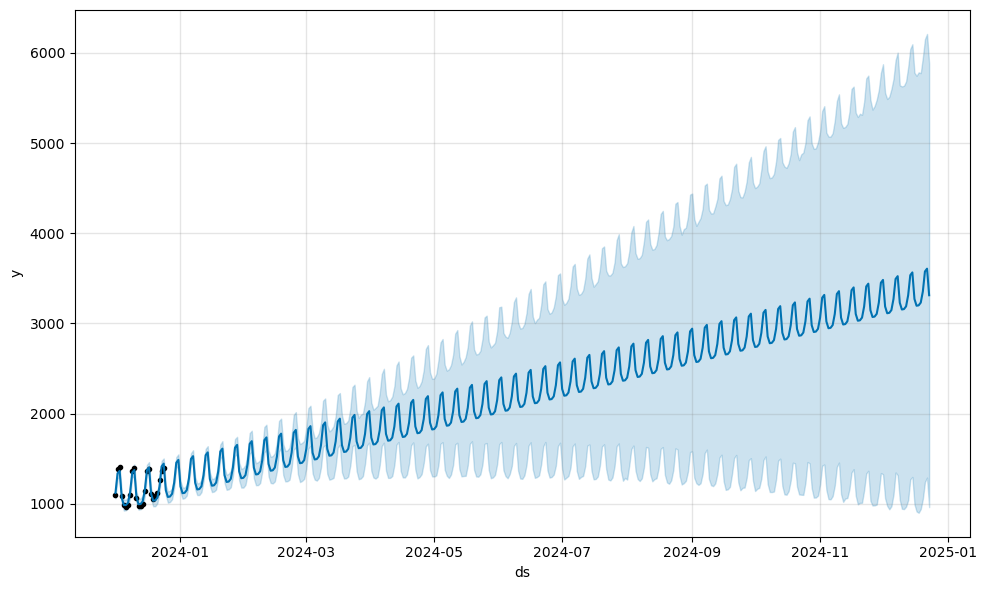

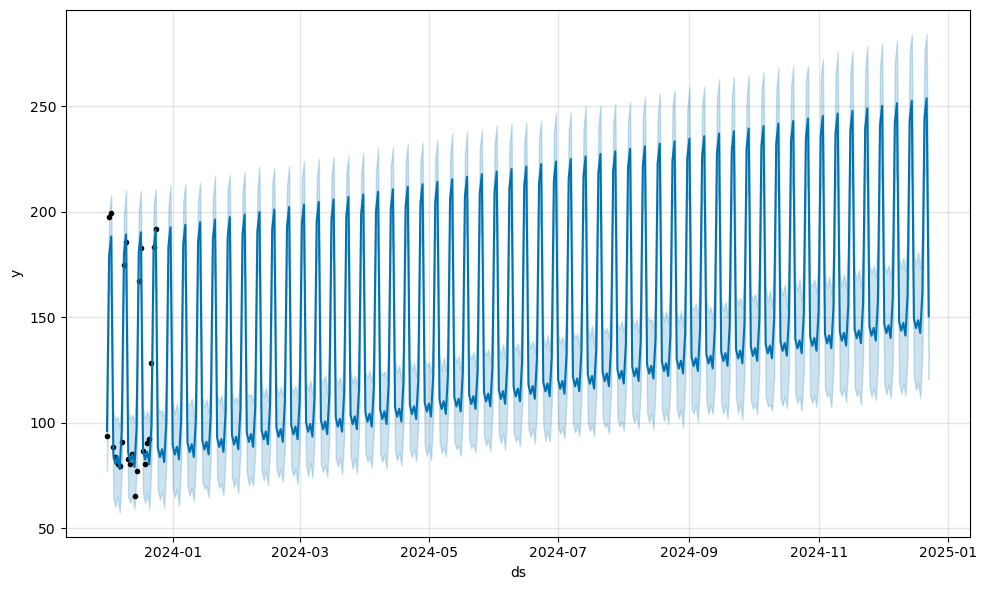

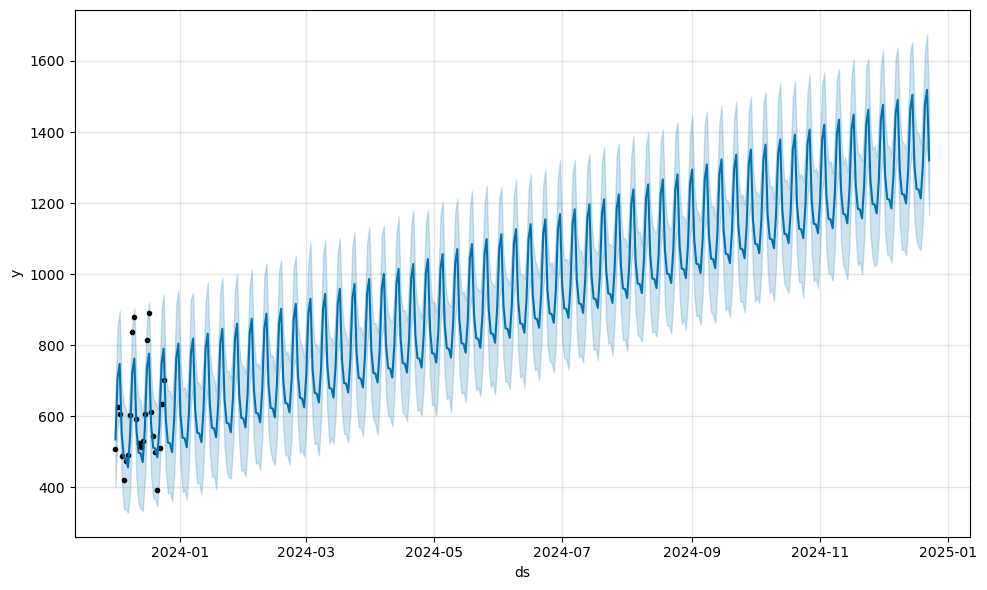

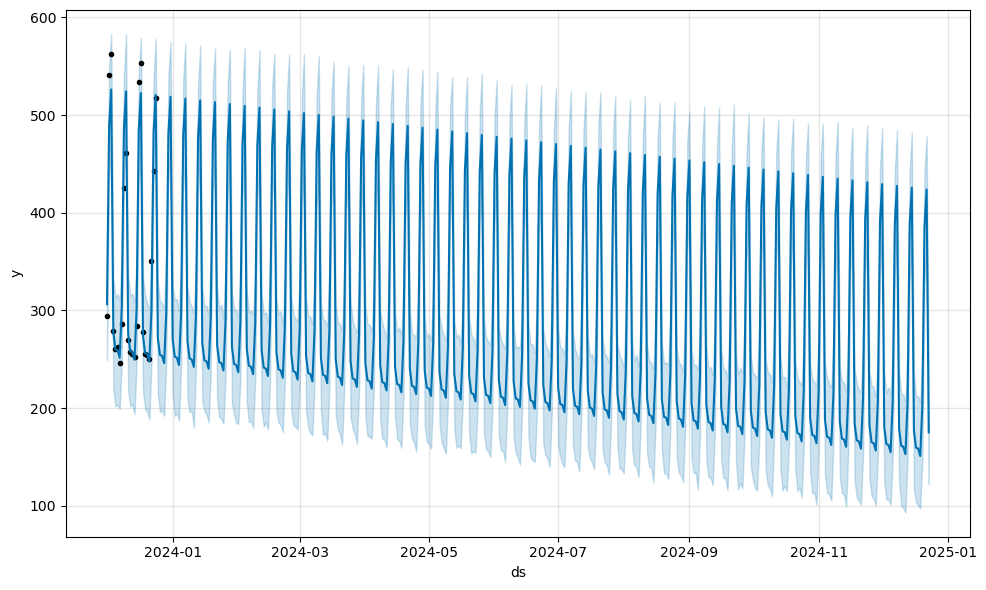

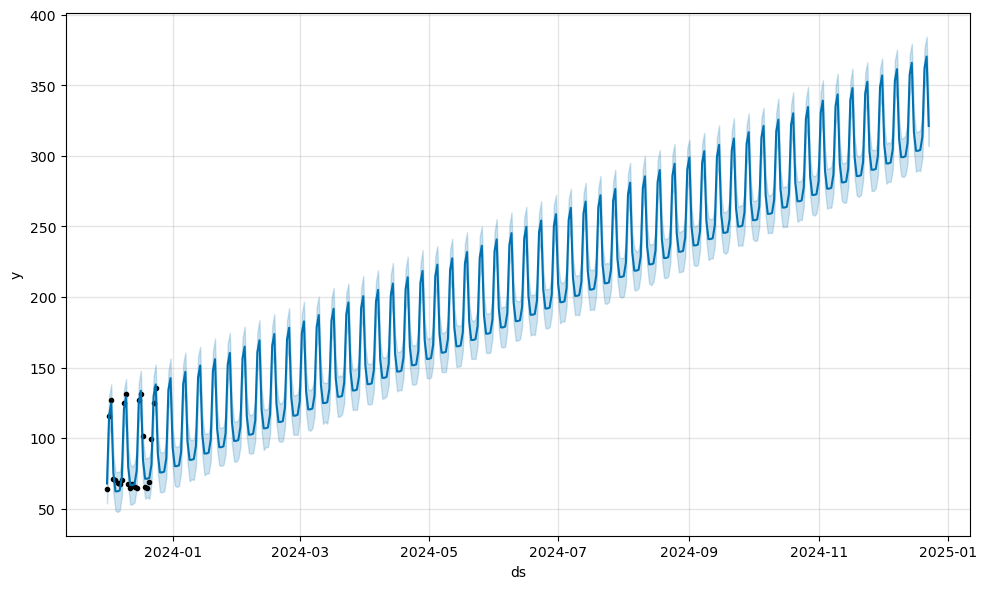

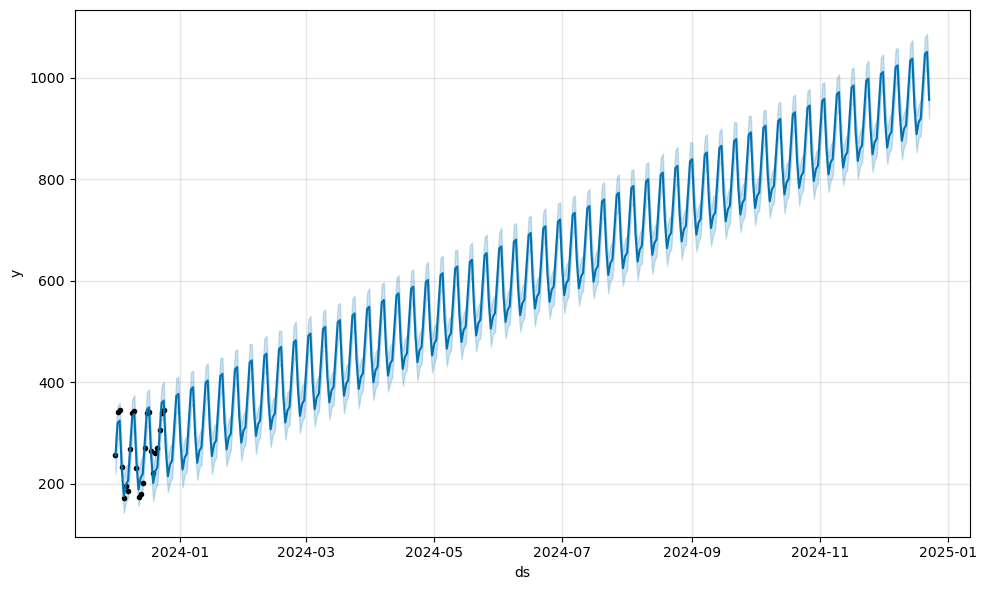

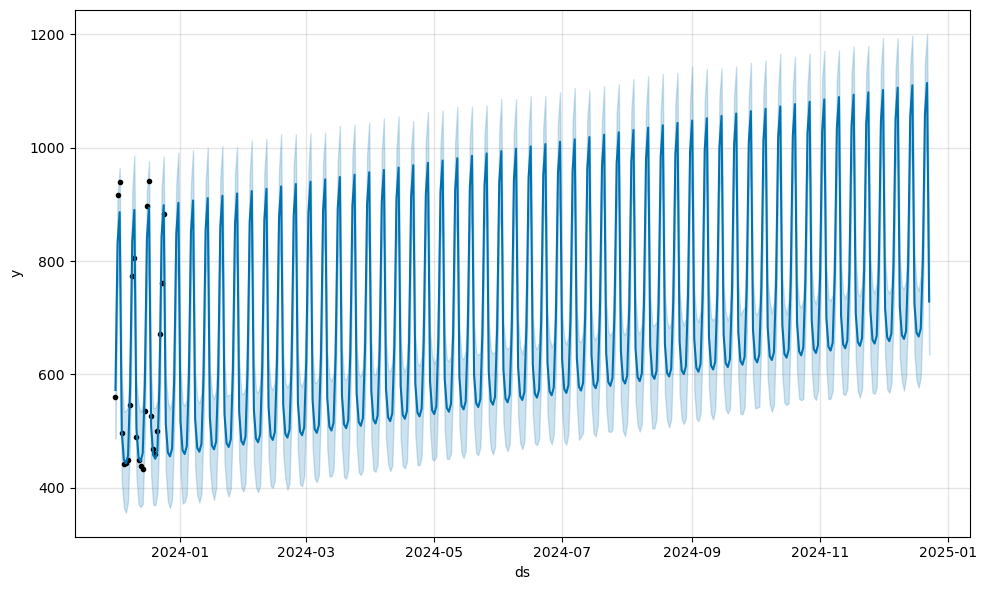

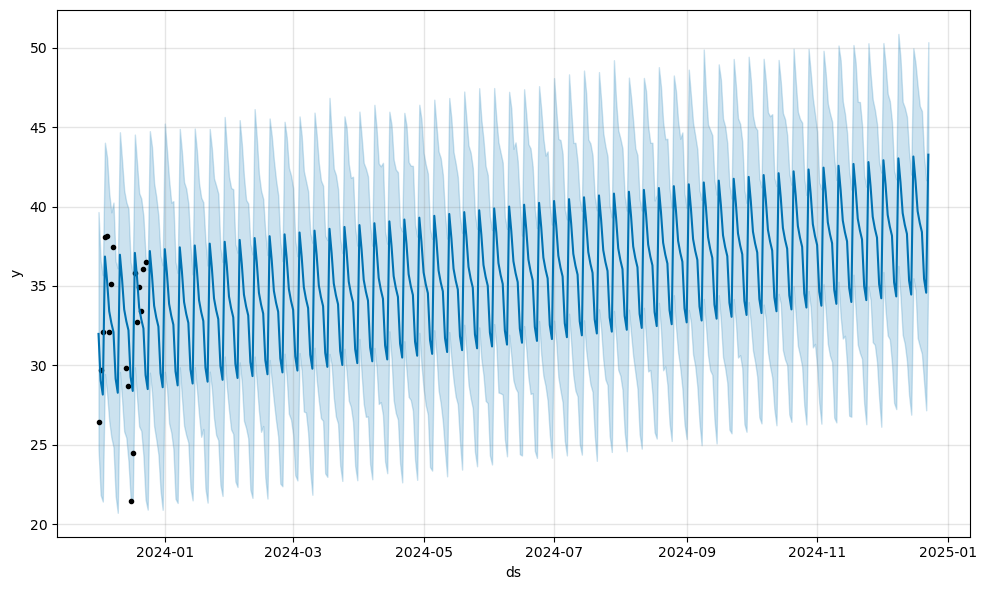

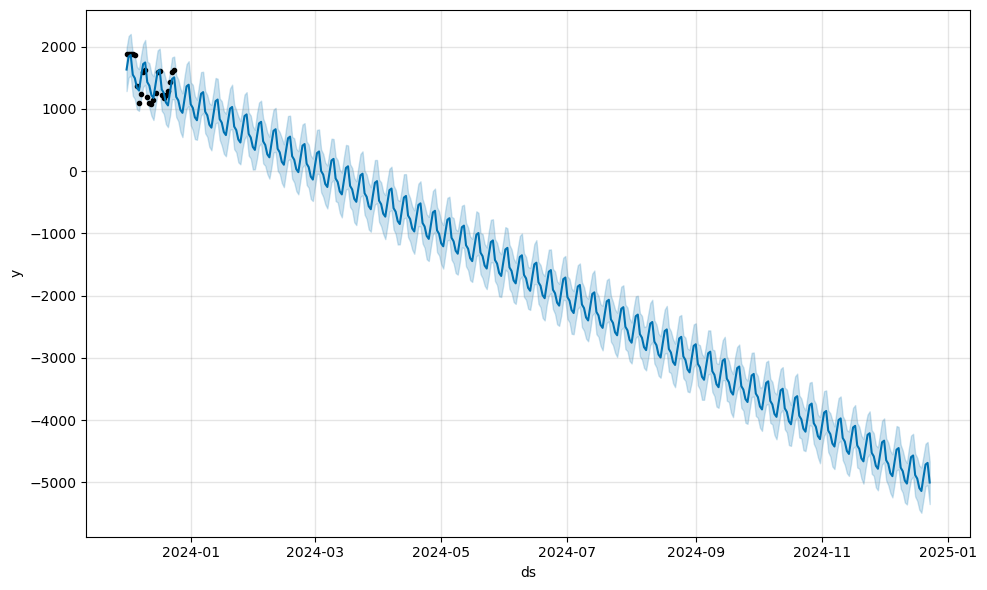

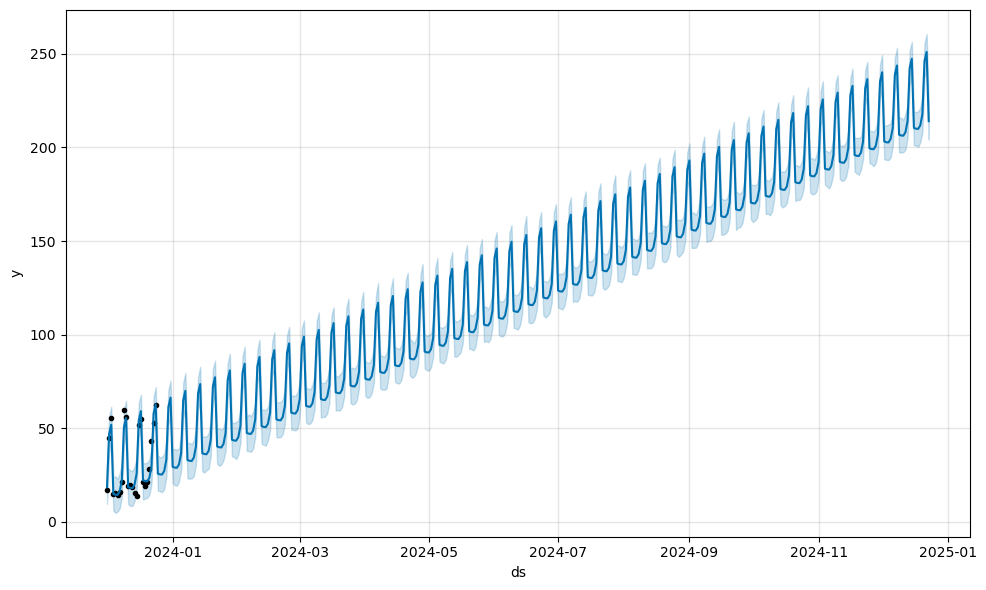

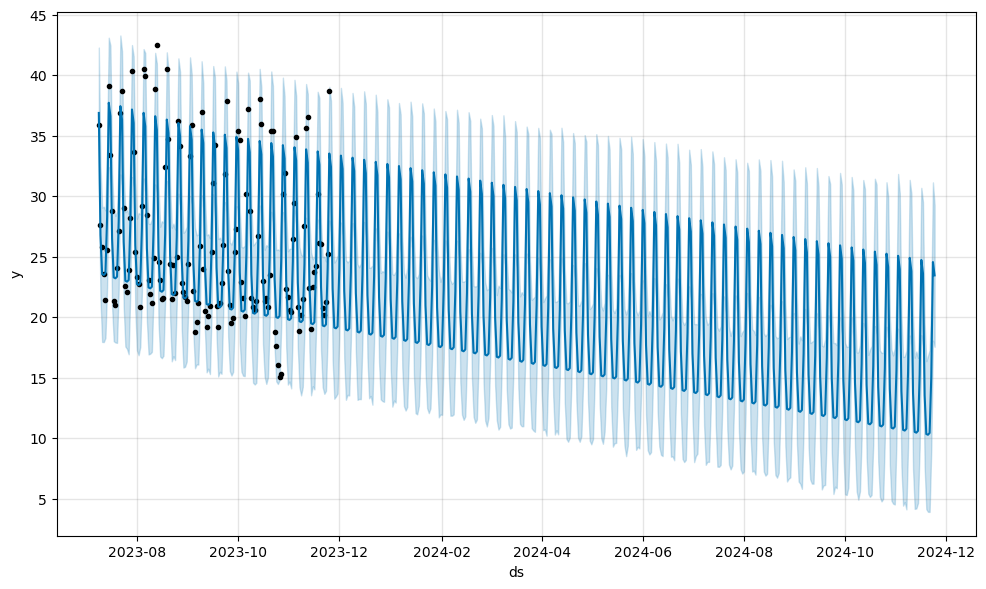

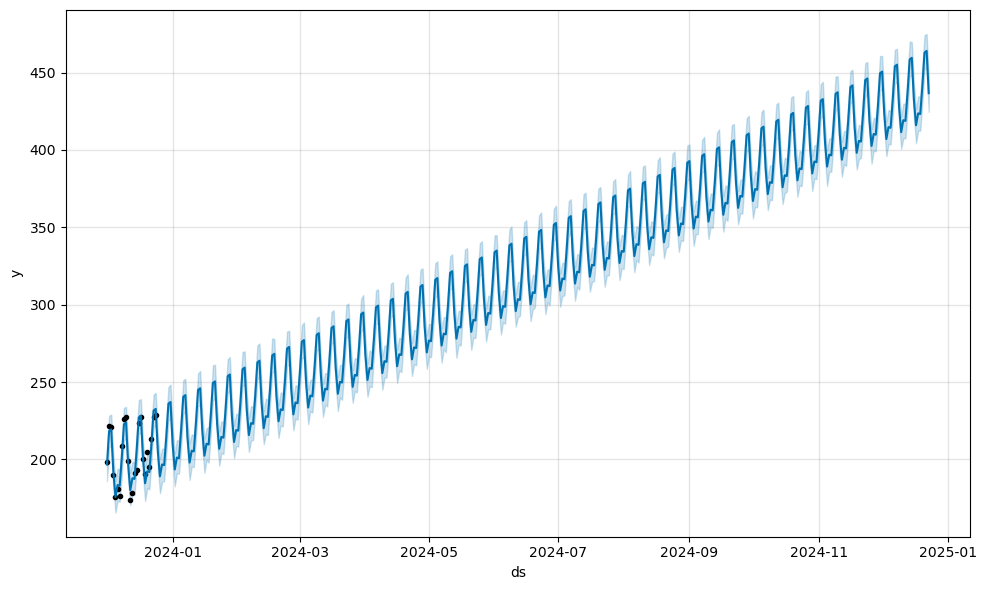

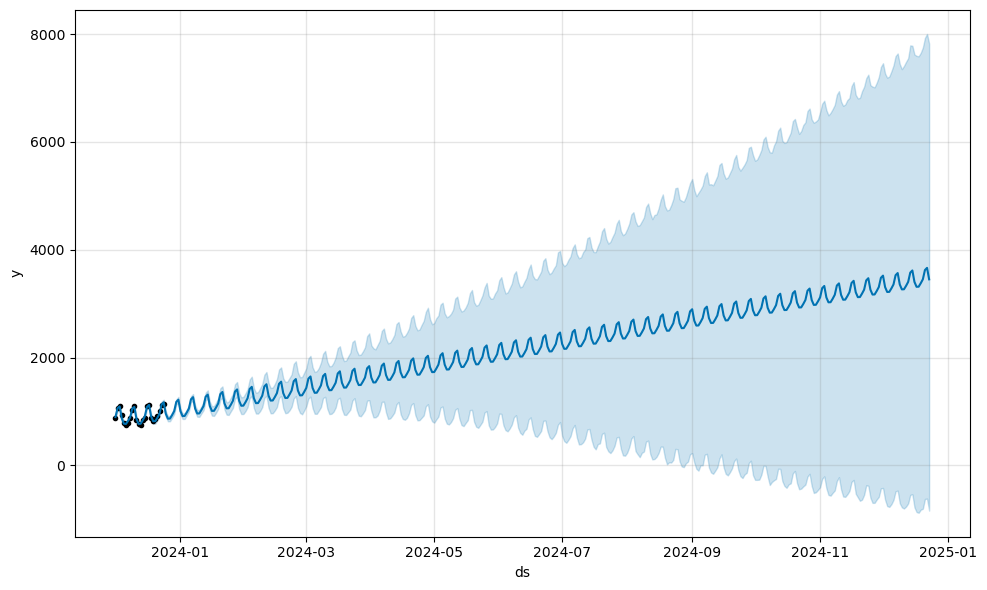

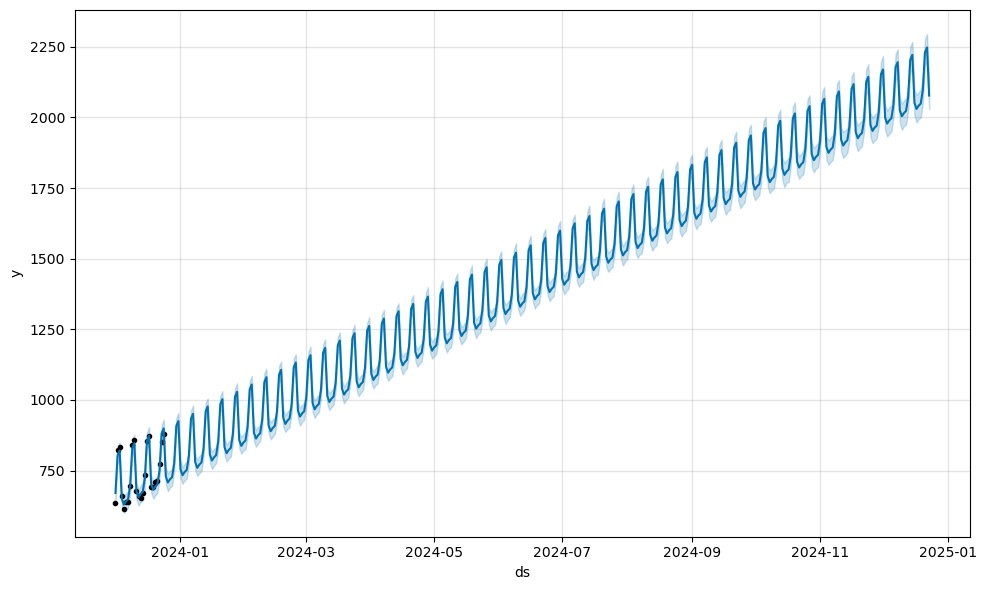

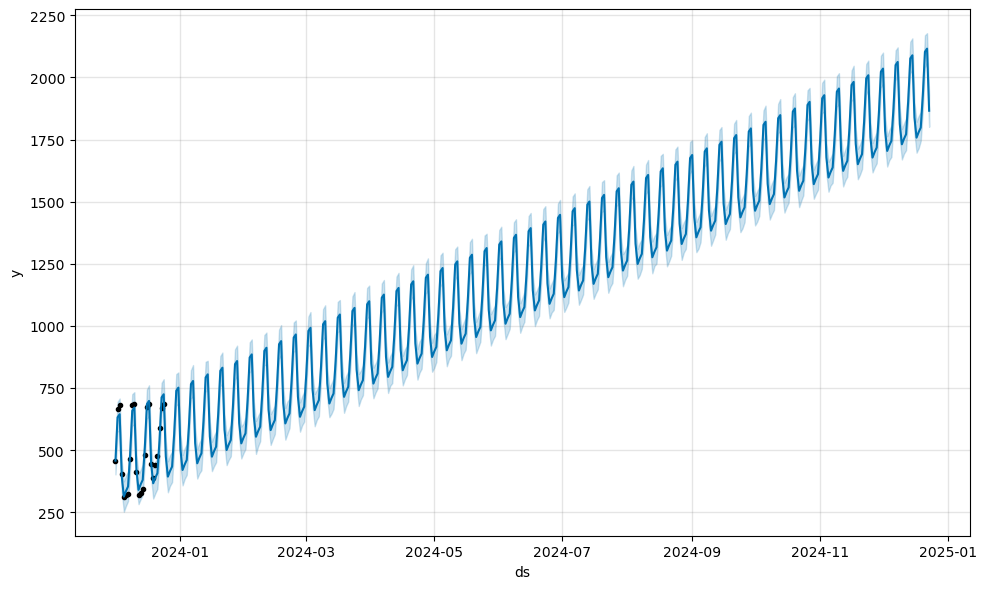

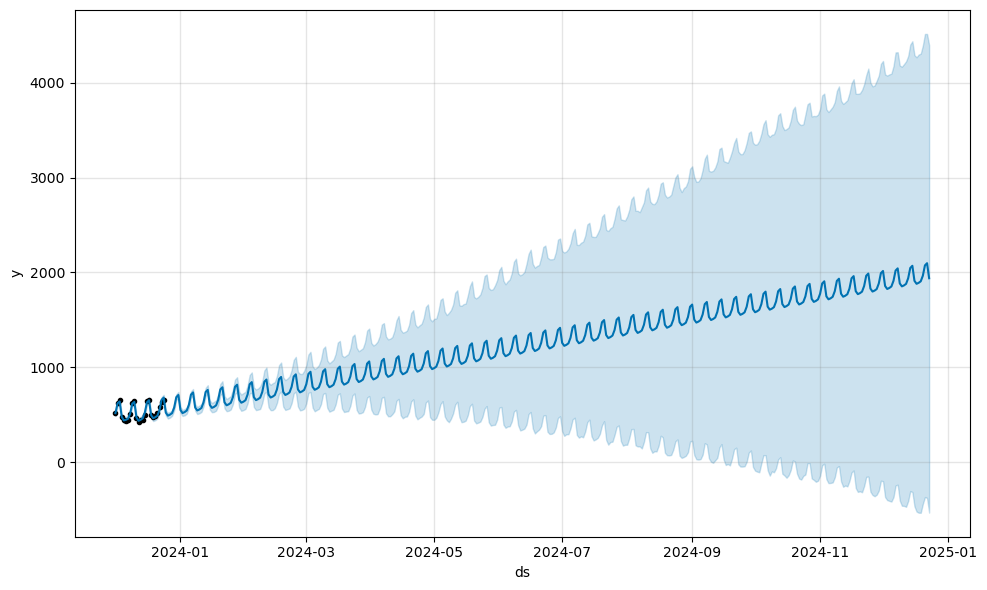

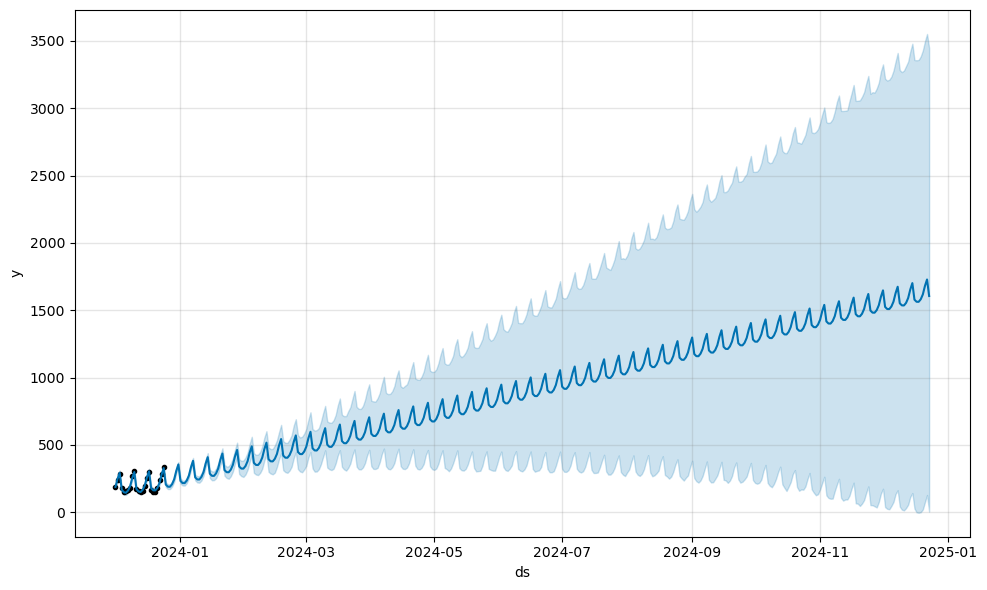

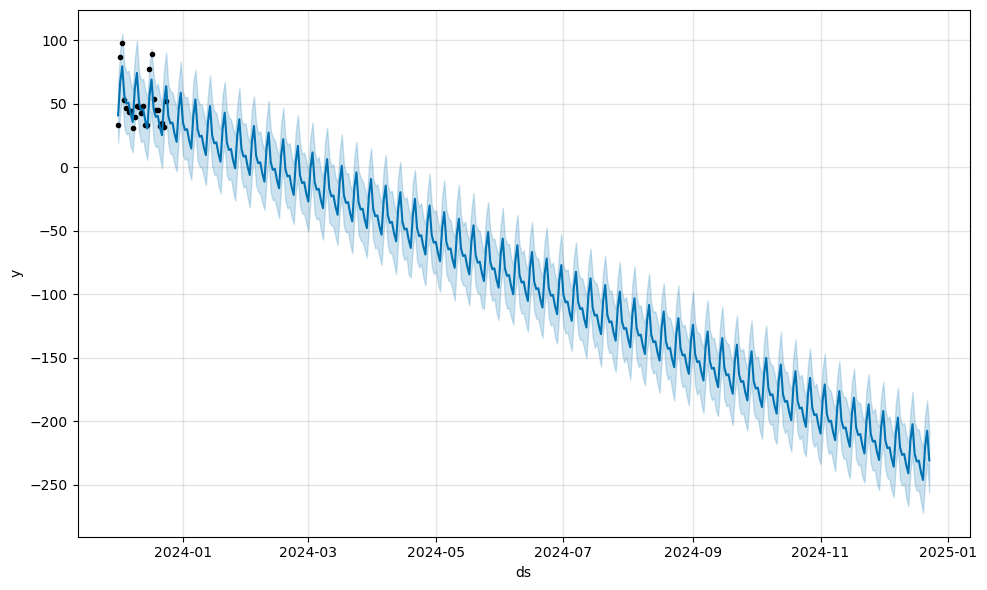

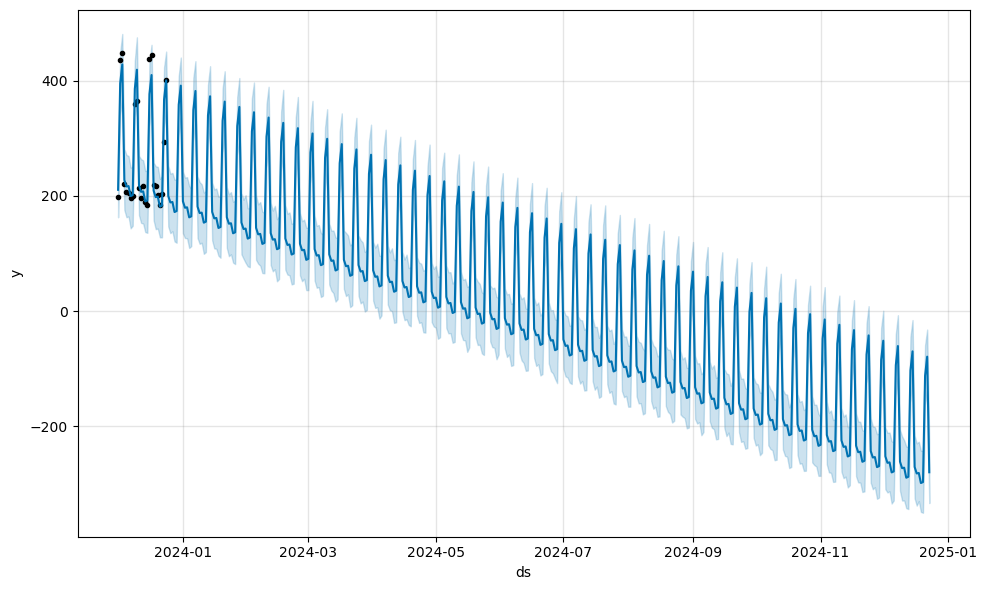

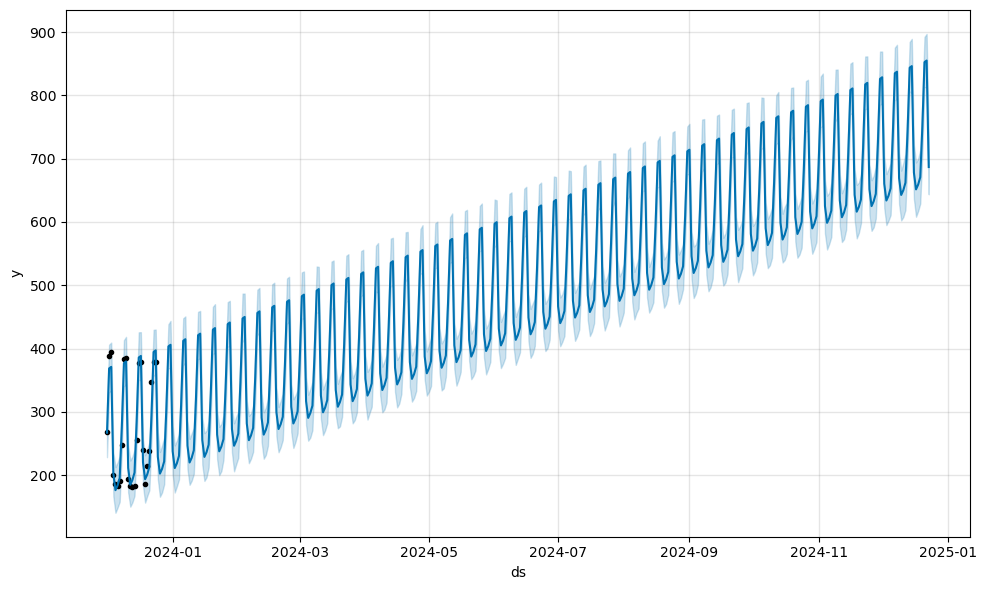

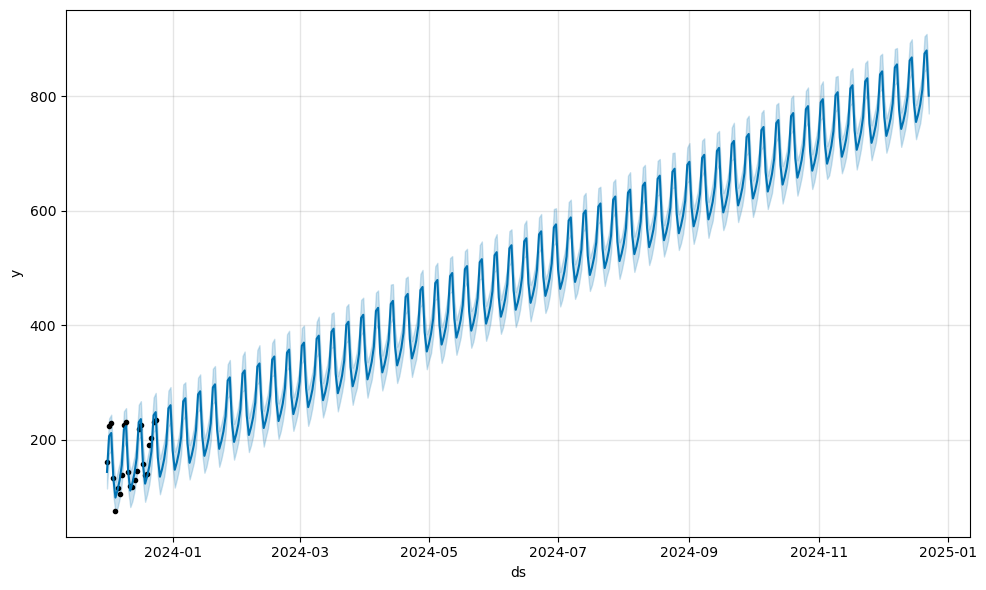

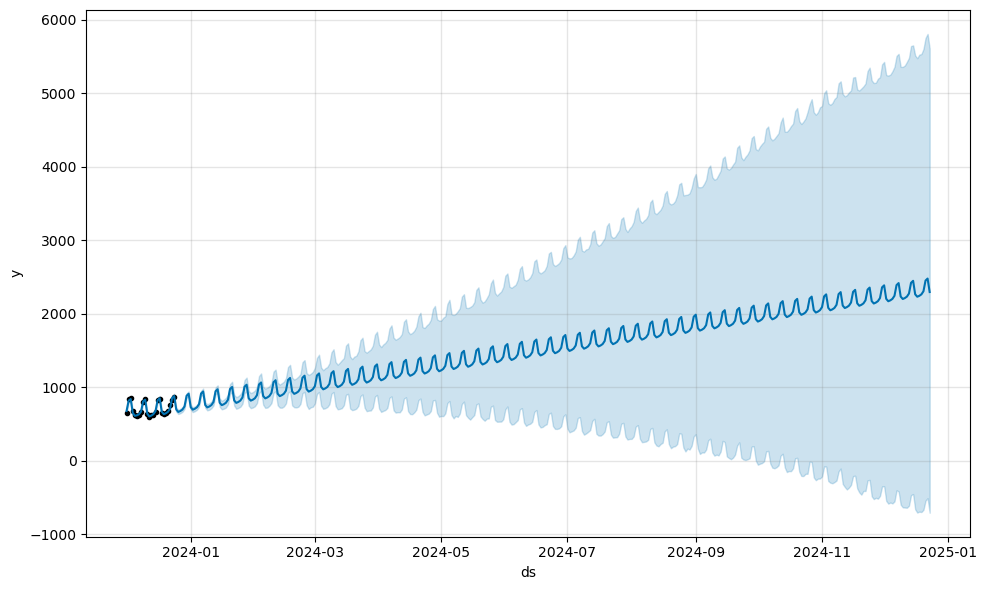

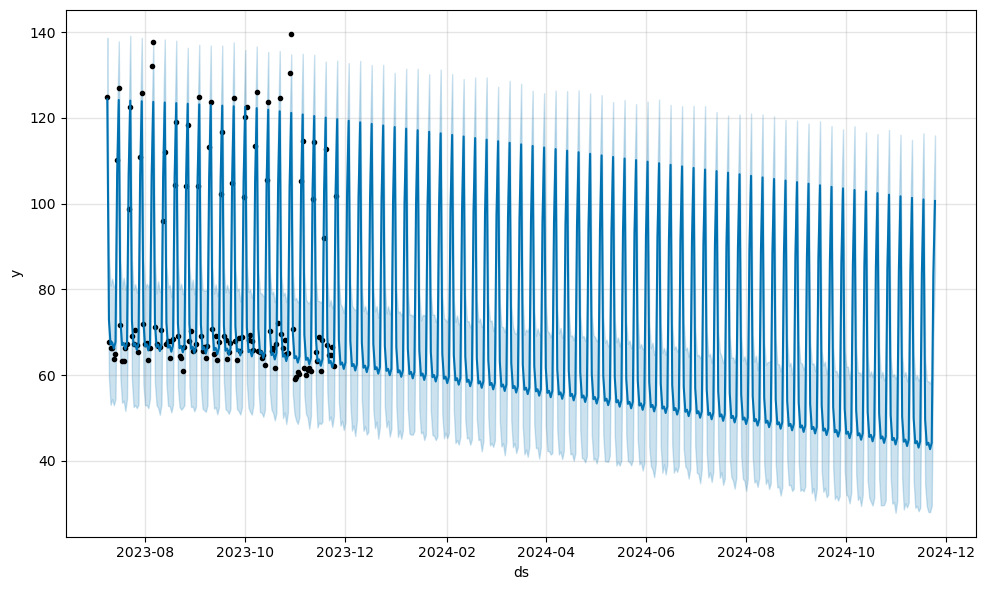

In [62]:
# Creating an empty dataframe
target = pd.DataFrame()

# Looping over facilities to perform forecasting
for facility in facility_names.groups:
    group = facility_names.get_group(facility)
    
    # Split the data into train and test sets
    train_data, test_data = train_test_split(group, test_size=0.2, shuffle=False)
    
    # display(group)
    
    # Check if there's enough data for training
    if len(train_data) > 2:  # Adjust the threshold as needed
        model = prophet.Prophet(interval_width=0.95)
        model.fit(train_data)
        
        # Create a future DataFrame
        future = model.make_future_dataframe(periods=365)
        
        # Generate forecasts
        forecast = model.predict(future)
        
        # Plot the forecast
        model.plot(forecast)
        
        # Rename columns in the forecast DataFrame
        forecast = forecast.rename(columns={"yhat": f"yhat_{facility}", "ds": "ds_forecast"})
        
        # Drop unnecessary columns before merging
        forecast = forecast[["ds_forecast", f"yhat_{facility}"]]
        
        # Merge with updated column names
        target = pd.merge(target, forecast.set_index("ds_forecast"), how="outer", left_index=True, right_index=True)
    else:
        # If there's not enough data for training, generate dummy forecasts
        forecast = pd.DataFrame({
            'ds_forecast': test_data['ds'],
            f'yhat_{facility}': [0] * len(test_data),
        })
    
    # Saving the model
    with open(f'./model/{facility}.pkl', 'wb') as f:
        pickle.dump(forecast, f)
    
    # Merge with updated column names
    target = pd.merge(target, forecast.set_index("ds_forecast"), how="outer", left_index=True, right_index=True)


The blackpoints on the plots are the actual `parking_availability` and the blue points  are the predicted values. The light blue background  represents the confidence interval which in our case is set to 95%

In [ ]:
target

In [ ]:
final_target = target[["yhat_"+facility for facility in facility_names.groups.keys()]]

In [ ]:
final_target

The dataframe above contains the forecast of the next 1 month based on the previous data the model has learned. We will plot the actual values versus the predicted values to see how  well our model is performing.

In [ ]:
#facilities names
facility_names = ["Bella Vista Car Park", "West Ryde Car Park", "Narrabeen Car Park",
                    "Warwick Farm Car Park", "Warriewood Car Park","Tallawong P2 Car Park",
                    "Tallawong P1 Car Park", "Sutherland East Parade Car Park", "St Marys Car Park", "Revesby Car Park",
                    "Penrith Combewood Multi-Level Car Park", "Penrith Combewood At-Grade Car Park", "Leppington Car Park",
                    "Kellyville South Car Park", "Kellyville North Car Park", "Hornsby Jersey St Car Park", "Hills Showground Car Park",
                    "Gordon Henry St North Car Park", "Edmondson Park South Car Park", "Dee Why Car Park", "Cherrybrook Car Park"]

# Loop through facility names
for facility in facility_names:
    # Get actual data for the facility from the original dataset
    actual_data = final_prophet_data.set_index("ds").query(f"facility_name == '{facility}'")["y"]

    # Get predicted data for the facility from the target DataFrame
    predicted_data = target[f"yhat_{facility}"]

    # Concatenate actual and predicted data
    combined_data = pd.concat([actual_data, predicted_data], axis=1)

    # Plot the actual vs predicted data 
    fig, ax = plt.subplots(figsize=(15, 5))
    combined_data.plot(ax=ax, title=f"Actual vs Predicted for {facility}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Values")
    ax.legend(["Actual", "Predicted"])


#### Saving the model
Using joblib/tensorflow/pickle

In [ ]:
joblib.dump(final_prophet_data, "./model/final_prophet_data.pkl")

From the plots we can see our model recognizes the seasonality of our data although it doesn't recognize the peaks and this can suggest doing a multivariate analysis to incorporate other exogenous(external)  variables such as holidays and weather to see if our model will recognize the peaks

#### Evaluating the model
The metrics used to evaluate timeseries  forecasting models are: MAE (Mean Absolute Error), RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error). We will use these metrics to evaluate our model

#### Multivariate Prophet modelling
As we saw in our initial model that the peaks couldn't be recognized when making predictions, we will go ahead and build another model that incorporates other external variables to see if the model will improve on realising the points it didn't recognize earlier 

In [ ]:
#our original dataframe
pprophet_data

In [ ]:
#setting datetime as index
second_prophet_data = pprophet_data.drop(["ParkID", "zone_id", "z_score", "time_category"], axis= 1)
#getting dummies
dummies_df = pd.get_dummies(second_prophet_data[['day_of_week']],
                            columns=["day_of_week"], prefix= ["day"])
#converting dummies to numerical
dummies_df = dummies_df.astype(int)
#joining the dummies and original df
final_df = pd.concat( [second_prophet_data, dummies_df] ,axis=1)
#dropping cat columns
final_df.drop( columns = "day_of_week", axis= 1, inplace = True)

In [ ]:

#inspecting our final df
final_df.head()


Now we have all columns in a format we can work with in machine learning. 

Lets resample the data into daily observations for easy handling

In [ ]:
#setting date to datetime
final_df['date_time'] = pd.to_datetime(final_df['date_time'])

# Set the datetime as index
final_df.set_index('date_time', inplace=True)
#resampling our data
final_data = final_df.groupby("facility_name").resample("D").mean()
#reset index
final_data = final_data.reset_index()

Renaming our columns in order to fit the prophet model

In [ ]:
#renaming columns
col_mapper  = {"date_time": "ds", "parking_availability": "y"}
#rename
final_data.rename(columns=col_mapper, inplace=True)
#inspecting
final_data.head()

Splitting our data into train and test

In [ ]:
# train= final_data[(final_data['ds'] >= '2023-06-01') & (final_data['ds'] <= '2023-09-31')] 
# test= final_data[(final_data['ds'] > '2023-09-31')]

Instantiating prophet model so we can start modelling 

In [ ]:

#grouping by facility in order to get predictions for each
parking_lots = final_data.groupby("facility_name")


In [ ]:
# Creating an empty dataframe
second_target = pd.DataFrame()

# Looping over facilities to perform forecasting
for facility in parking_lots.groups:
    group = parking_lots.get_group(facility)
    
    # Instantiate the model
    prophet_model = prophet.Prophet(interval_width=0.95, daily_seasonality= False)
    
    #Adding regressors to the model
    for col in dummies_df.columns:
        prophet_model.add_regressor(col)
    
    # Fit the model to the data
    prophet_model.fit(group)
    
    # Create a future DataFrame with regressors
    future = prophet_model.make_future_dataframe(periods=31)
    
    for col in dummies_df.columns:
        future[col] = dummies_df[col]
    
    # Generate forecasts
    forecast = prophet_model.predict(future)
    final_data
    # Plot the forecast
    prophet_model.plot(forecast)
    
    # Rename columns in the forecast DataFrame
    forecast = forecast.rename(columns={"yhat": f"yhat_{facility}", "ds": "ds_forecast"})
    
    # Drop unnecessary columns before merging
    forecast = forecast[["ds_forecast", f"yhat_{facility}"]]
    
    # Merge with updated column names
    second_target = pd.merge(second_target, forecast.set_index("ds_forecast"), how="outer", left_index=True, right_index=True)


Plotting actual versus predicted

In [ ]:
#facilities names
facility_names = ["Bella Vista Car Park", "West Ryde Car Park", "Narrabeen Car Park",
                    "Warwick Farm Car Park", "Warriewood Car Park","Tallawong P2 Car Park",
                    "Tallawong P1 Car Park", "Sutherland East Parade Car Park", "St Marys Car Park", "Revesby Car Park",
                    "Penrith Combewood Multi-Level Car Park", "Penrith Combewood At-Grade Car Park", "Leppington Car Park",
                    "Kellyville South Car Park", "Kellyville North Car Park", "Hornsby Jersey St Car Park", "Hills Showground Car Park",
                    "Gordon Henry St North Car Park", "Edmondson Park South Car Park", "Dee Why Car Park", "Cherrybrook Car Park"]

# Loop through facility names
for facility in facility_names:
    # Get actual data for the facility from the original dataset
    actual_data = final_data.set_index("ds").query(f"facility_name == '{facility}'")["y"]

    # Get predicted data for the facility from the target DataFrame
    predicted_data = second_target[f"yhat_{facility}"]

    # Concatenate actual and predicted data
    combined_data = pd.concat([actual_data, predicted_data], axis=1)

    # Plot the actual vs predicted data 
    fig, ax = plt.subplots(figsize=(15, 5))
    combined_data.plot(ax=ax, title=f"Actual vs Predicted for {facility}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Values")
    ax.legend(["Actual", "Predicted"])

Evaluating the model using metrics

In [ ]:
# mse = mean_squared_error(final_data['y'], forecast["yhat"][-len(actual_data):])
# rmse = np.sqrt(mse)
# mae = mean_absolute_error()

## LSTM

In [ ]:
#variables
sequence_length = 5
features = 5
epochs = 15
batch_size = 32
# to scale
columns_to_scale = ['total_parking_spots', 'occupancy_total', 'y']
#Extract columns to scale
to_scale = final_data[columns_to_scale]
#MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit and transform 
scaled_data = scaler.fit_transform(to_scale)
# Create a DataFrame 
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
# Add scaled columns back to the original DataFrame
final_data[columns_to_scale] = scaled_df

# Display the result
final_data.head()

Now our data is ready for Neural Networks training. First we are going to set the datetime as the index.


In [ ]:
#setting ds as index
final_data.set_index("ds", inplace= True)

In [ ]:
final_data

### XGBOOST for Time Series
XGBoost for time series involves transforming time-related features and historical observations into a structured input for the model. Incorporating relevant temporal information can enhance its ability to capture patterns, trends, and seasonality, improving forecasting accuracy. Experimentation with feature engineering and model parameters is crucial for optimizing performance in time series applications.

In [ ]:
#our initial dataframe
modelling_data.head()

Since XGBOOST enjoys working with incorporated relevant temporal features, we are going to feature engineer our `timestamp`  column by creating new columns that capture the day of the week the hour of the day and minute

In [ ]:
#resetting index
xgboost_data = modelling_data.reset_index()
#inspecting the df
xgboost_data.head()

In [ ]:
#confirming timestamp dtype
print(xgboost_data["timestamp"].dtype)

In [ ]:
#feature engineering timestamp
xgboost_data["year"] = xgboost_data["timestamp"].dt.year
xgboost_data["month"] = xgboost_data["timestamp"].dt.month
xgboost_data["hour"] = xgboost_data["timestamp"].dt.hour
xgboost_data["minute"] = xgboost_data["timestamp"].dt.minute
#inspecting df
xgboost_data.head()

In [ ]:
vanilla_data =  xgboost_data.drop(["day_of_week", "time_category", "z_score"], axis= 1)
vanilla_data = vanilla_data.set_index("timestamp")


In [ ]:
xg_dummies = pd.get_dummies(xgboost_data[['day_of_week', 'time_category']],
                            columns=["day_of_week", "time_category"], prefix= ["day_of_the_week", "time_period"],
                            sparse= False, drop_first= True)
#converting dummies to numerical
xg_dummies = xg_dummies.astype(int)
#joining the dummies and original df
xg_encoded = pd.concat( [xgboost_data, xg_dummies] ,axis=1)
#dropping cat columns
xg_encode = xg_encoded.drop(["time_category", "day_of_week", "z_score"], axis= 1)
xg_encoded = xg_encoded.set_index("timestamp")

In [ ]:
vanilla_data =  xgboost_data.drop(["day_of_week", "time_category", "z_score"], axis= 1)
vanilla_data = vanilla_data.set_index("timestamp")

xg_grouped = vanilla_data.groupby("facility_name")

import xgboost as xgb
from datetime import timedelta

# Dictionary to store XGBoost models for each parking lot
xg_models = {}

# Train a model for each parking lot
for facility_name, group_data in xg_grouped:
    # Split the data into features and target variable
    X = group_data.drop(columns=["parking_availability", "facility_name"], axis=1)
    y = group_data["parking_availability"]

    # Create an XGBoost model
    xg_model = xgb.XGBRegressor(objective='reg:squarederror')

    # Train the model
    xg_model.fit(X, y)

    # Make predictions on the entire dataset
    group_data["prediction"] = xg_model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, group_data["prediction"])
    rmse = sqrt(mse)
    mae = mean_absolute_error(y,group_data["prediction"])
    print(f'Mean Squared Error for {facility_name}: {mse}')
    print(f'Root Mean Squared Error for {facility_name}: {rmse}')
    print(f'Mean Absolute Error for {facility_name}: {mae}')
    # Store the trained model in the dictionary
    xg_models[facility_name] = xg_model

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(group_data.index, y, label='Actual', marker='o')
    plt.plot(group_data.index, group_data["prediction"], label='Predicted', marker='o')
    plt.title(f'Actual vs Predicted for {facility_name}')
    plt.xlabel('Date')
    plt.ylabel('Parking Availability')
    plt.legend()
    plt.show()

    
    # #prediction_function
    # def generate_features_for_next_31_days(future_dates):
    #     future_X = pd.DataFrame(index=future_dates)

    #     # Example: Generating random values for demonstration purposes
    #     future_X["total_parking_spots"] = [10, 12, 15, 18, 20, 22, 25, 28, 30, 32, 35, 38, 40, 42, 45, 48, 50, 52, 55, 58, 60, 62, 65, 68, 70, 72, 75, 78, 80, 82, 85]
    #     future_X["occupancy_total"] = [5, 8, 10, 12, 15, 18, 20, 22, 25, 28, 30, 32, 35, 38, 40, 42, 45, 48, 50, 52, 55, 58, 60, 62, 65, 68, 70, 72, 75, 78, 80, 82]
    #     future_X["year"] = [date.year for date in future_dates]
    #     future_X["month"] = [date.month for date in future_dates]
    #     future_X["hour"] = [date.hour for date in future_dates]
    #     future_X["minute"] = [date.minute for date in future_dates]
    #     future_X["day"] = [date.day for date in future_dates]

    #     return future_X

    # # Make predictions for the next 31 days
    
    # future_dates = group_data.index + timedelta(days=31)
    # future_X = generate_features_for_next_31_days(future_dates)  # You need to implement this function
    # future_predictions = xg_model.predict(future_X)

    # # Plot future predictions
    # plt.figure(figsize=(15, 6))
    # plt.plot(future_dates, future_predictions, label='Future Predictions', marker='o')
    # plt.title(f'Future Predictions for {facility_name}')
    # plt.xlabel('Date')
    # plt.ylabel('Parking Availability')
    # plt.legend()
    # plt.show()


Our model is learning too perfectly from the training data such that we cannot see the plot of actual data points because they have been covered by the predicted values.

We will add some few other columns and penalties to see if it will improve

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = { 
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 6, 7],
    "gamma": [0, 0.1, 0.2],
    "lambda": [0, 0.01,  0.1],
    "alpha": [0, 0.01, 0.1, 0.2],
    "n_estimators": [20, 40, 50]
}

# # Dictionary to store XGBoost models for each parking lot
# xg_models = {}

# # Train a model for each parking lot
# for facility_name, group_data in xg_grouped:
#     # Split the data into features and target variable
#     X = group_data.drop(columns=["parking_availability", "facility_name"], axis=1)
#     y = group_data["parking_availability"]

#     # Create an XGBoost model
#     xg_model = xgb.XGBRegressor(objective='reg:squarederror')

#     # Perform GridSearchCV
#     grid_search = GridSearchCV(xg_model, param_grid=param_grid, cv=3, n_jobs=-1)
#     grid_search.fit(X, y)

#     # Get the best hyperparameters
#     best_params = grid_search.best_params_
#     print(f'Best Hyperparameters for {facility_name}: {best_params}')

#     # Use the best model from GridSearchCV
#     best_model = grid_search.best_estimator_

#     # Train the model
#     best_model.fit(X, y)

#     # Make predictions on the entire dataset
#     group_data["prediction"] = best_model.predict(X)

#     # Evaluate the model
#     mse = mean_squared_error(y, group_data["prediction"])
#     rmse = sqrt(mse)
#     mae = mean_absolute_error(y, group_data["prediction"])
#     print(f'Mean Squared Error for {facility_name}: {mse}')
#     print(f'Root Mean Squared Error for {facility_name}: {rmse}')
#     print(f'Mean Absolute Error for {facility_name}: {mae}')

#     # Store the trained model in the dictionary
#     xg_models[facility_name] = best_model

#     # Plot actual vs predicted values
#     plt.figure(figsize=(10, 5))
#     plt.plot(group_data.index, y, label='Actual', marker='o')
#     plt.plot(group_data.index, group_data["prediction"], label='Predicted', marker='o')
#     plt.title(f'Actual vs Predicted for {facility_name}')
#     plt.xlabel('Date')
#     plt.ylabel('Parking Availability')
#     plt.legend()
#     plt.show()

Now that we have our best parameters for the Xgboost model. We are going to build final models for each time series and make predictions with it.


In [ ]:
# # Define the parameter grid for GridSearchCV
# param_grid = { 
#     "learning_rate": [0.01, 0.1, 0.2],
#     "max_depth": [3, 5, 6, 7],
#     "gamma": [0, 0.1, 0.2],
#     "lambda": [0, 0.01,  0.1],
#     "alpha": [0, 0.01, 0.1, 0.2],
#     "n_estimators": [20, 40, 50]
# }
# #class XGBOOST
# class XGBoostTimeSeriesModel:
#     def __init__(self, param_grid, target_variable='parking_availability', cv=3, n_jobs=-1):
#         self.param_grid = param_grid
#         self.target_variable = target_variable
#         self.cv = cv
#         self.n_jobs = n_jobs
#         self.models = {}

#     def _get_features_target(self, group_data):
#         X = group_data.drop(columns=[self.target_variable, "facility_name"], axis=1)
#         y = group_data[self.target_variable]
#         return X, y

#     def train_models(self, xg_grouped):
#         for facility_name, group_data in xg_grouped:
#             X, y = self._get_features_target(group_data)

#             # Create an XGBoost model
#             xg_model = xgb.XGBRegressor(objective='reg:squarederror')

#             # Perform GridSearchCV
#             grid_search = GridSearchCV(xg_model, param_grid=self.param_grid, cv=self.cv, n_jobs=self.n_jobs)
#             grid_search.fit(X, y)

#             # Get the best hyperparameters
#             best_params = grid_search.best_params_
#             # print(f'Best Hyperparameters for {facility_name}: {best_params}')

#             # Use the best model from GridSearchCV
#             best_model = grid_search.best_estimator_

#             # Train the model
#             best_model.fit(X, y)

#             # Store the trained model in the dictionary
#             self.models[facility_name] = best_model

#     def predict_and_plot(self, xg_grouped):
#         for facility_name, model in self.models.items():
#             # Get the last available data for each facility
#             last_data = xg_grouped.get_group(facility_name).tail(1).drop(columns=["parking_availability", "facility_name"])

#             # Make predictions for the next time period
#             facility_predictions = model.predict(last_data)

#             # Plot actual vs predicted values
#             group_data = xg_grouped.get_group(facility_name)
#             plt.figure(figsize=(10, 5))
#             plt.plot(group_data.index, group_data[self.target_variable], label='Actual', marker='o')
#             plt.plot(group_data.index, group_data["prediction"], label='Predicted', marker='o')
#             plt.title(f'Actual vs Predicted for {facility_name}')
#             plt.xlabel('Date')
#             plt.ylabel('Parking Availability')
#             plt.legend()
#             plt.show()

# # Example usage:
# xg_model = XGBoostTimeSeriesModel(param_grid)
# xg_model.train_models(xg_grouped)
# xg_model.predict_and_plot(xg_grouped)


### LSTM 
Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture designed to address the vanishing gradient problem in traditional RNNs. LSTMs have a unique memory cell, input gate, forget gate, and output gate, allowing them to capture and remember long-term dependencies in sequential data. They are widely used for tasks involving time series prediction, natural language processing, and other sequential data applications.


In [ ]:

# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# class CarParkLSTM:
#     def __init__(self, df, facility_name, target_variable = "availability", sequence_length =10, epochs = 50, batch_size = 32):
#         self.df = df[df["facility_name"] == facility_name].copy()
#         self.target_variable = target_variable
#         self.sequence_length = sequence_length
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.scaler = MinMaxScaler(feature_range=(0, 1))
#         self.model = self.build_model()

#     def build_model(self):
#         model = Sequential()
#         model.add(LSTM(units=50, activation='relu', input_shape=(self.sequence_length, 1)))
#         model.add(LSTM(units=30, activation='relu', input_shape=(self.sequence_length, 1)))
#         model.add(Dense(units=1))
#         model.compile(optimizer='adam', loss='mean_squared_error')
#         return model

#     def prepare_data(self):
#         # Scale the target variable values between 0 and 1
#         self.df['scaled_target'] = self.scaler.fit_transform(self.df[self.target_variable].values.reshape(-1, 1))

#         # Create sequences of data for training
#         data = self.df['scaled_target'].values
#         sequences = []
#         for i in range(len(data) - self.sequence_length):
#             sequences.append(data[i:i + self.sequence_length])
#         sequences = np.array(sequences)

#         # Split data into input (X) and output (y)
#         X = sequences[:, :-1]
#         y = sequences[:, -1]

#         # Reshape for LSTM input shape (samples, time steps, features)
#         X = X.reshape(X.shape[0], X.shape[1], 1)

#         return X, y

#     def train_model(self):
#         X, y = self.prepare_data()
#         self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

#     def predict(self, future_periods=7):
#         last_sequence = self.df['scaled_target'].values[-self.sequence_length:]
#         last_sequence = last_sequence.reshape(1, -1, 1)
#         predictions_scaled = []

#         for _ in range(future_periods):
#             prediction_scaled = self.model.predict(last_sequence)
#             predictions_scaled.append(prediction_scaled[0, 0])
#             last_sequence = np.append(last_sequence[:, 1:, :], [[prediction_scaled[0, 0]]], axis=1)

#         predictions_scaled = np.array(predictions_scaled)
#         predictions = self.scaler.inverse_transform(predictions_scaled.reshape(-1, 1))

#         return predictions

#     def provide_forecast(self, start_datetime, forecast_period=7):
#         self.train_model()

#         # Find the last available datetime in the dataset
#         last_datetime = self.df['timestamp'].max()

#         # Generate a sequence of datetimes for forecasting
#         forecast_datetimes = pd.date_range(start=last_datetime + pd.Timedelta(minutes=15), periods=forecast_period*96, freq='15T')

#         # Make predictions for the specified period
#         predictions = self.predict(forecast_period*96)

#         # Create a DataFrame with forecast datetimes and predictions
#         forecast_df = pd.DataFrame({'timestamp': forecast_datetimes, 'predicted_availability': predictions.flatten()})

#         # Filter forecast for the specified start datetime and period
#         forecast_result = forecast_df[forecast_df['timestamp'] >= start_datetime].head(forecast_period)

#         return forecast_result

#     def plot_predictions(self, future_periods=7):
#         self.train_model()
#         predictions = self.predict(future_periods)

#         plt.figure(figsize=(12, 6))
#         plt.plot(self.df['timestamp'], self.df[self.target_variable], label='Actual Availability', marker='o')
#         plt.plot(pd.date_range(start=self.df['timestamp'].iloc[-1], periods=future_periods*96 + 1, freq='15T')[1:],
#                 predictions, label='Predicted Availability', marker='o')
#         plt.title(f"Car Park Facility {self.df['facility_name'].iloc[0]} Availability Prediction")
#         plt.xlabel('Date')
#         plt.ylabel('Availability')
#         plt.legend()
#         plt.show()

# # Example usage:
# # Assuming your DataFrame is named 'car_park_data' with columns 'timestamp', 'facility_name', and 'availability'
# for facility_name in xg_grouped['facility_name'].unique():
#     lstm_model = CarParkLSTM(df= xg_grouped, facility_name=facility_name, target_variable='y')
#     lstm_model.plot_predictions(future_periods=7)

# # For providing forecasts for a specific period
# forecast_start_datetime = pd.to_datetime('2024-02-11 12:00:00') # Enter the desired start datetime
# forecast_period = 7 # Enter the desired forecast period (in days)
# forecast_result = lstm_model.provide_forecast(start)
# print(forecast_result)
